In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

$\textbf{Introduction}$

- We examine data compression tools of the PCA and the Neural Network Autoencoder
- We examine their performance both with training data and out of sample test set data
- One of the key lessons is that for the nonlinear method, it is very important to squash the data
- Otherwise the optimal parameters will likely not converge to the minimum sum of squared errors
- We read in a large spread sheet with Hong Kong and US Swap Option volatilities for various maturieis
- Obivously there are more swap option volatility quotes for the US than for Hong Kong
- We should like to know how they interrelate and influence one another
- Since Hong Kong has a credible fixed exchange rate with the US dollar, any differences would not be due to currency risk
- Significnat differences would relect $\textit{idiosyncratic risk}$.


        Date  HDSV0A2 Curncy  HDSV0A1 Curncy  HDSV0210 Curncy  HDSV101 Curncy  \
0 2005-05-25            30.5            37.5            18.70           18.00   
1 2005-05-26            31.5            37.5            18.80           18.00   
2 2005-05-27            30.5            36.0            18.80           17.90   
3 2005-05-30            31.0            35.5            18.80           17.90   
4 2005-05-31            30.5            35.0            18.85           18.05   

   HDSV015 Curncy  HDSV0110 Curncy  HDSV0C2 Curncy  USSN0C10 Curncy  \
0           23.60            20.00           30.70            83.60   
1           23.60            20.10           30.30            83.60   
2           23.60            20.20           30.60            82.15   
3           23.60            20.10           30.60            82.15   
4           22.55            18.75           28.75            83.30   

   USSN0110 Curncy  ...  USSN036 Curncy  USSN038 Curncy  USSN039 Curncy  \
0          

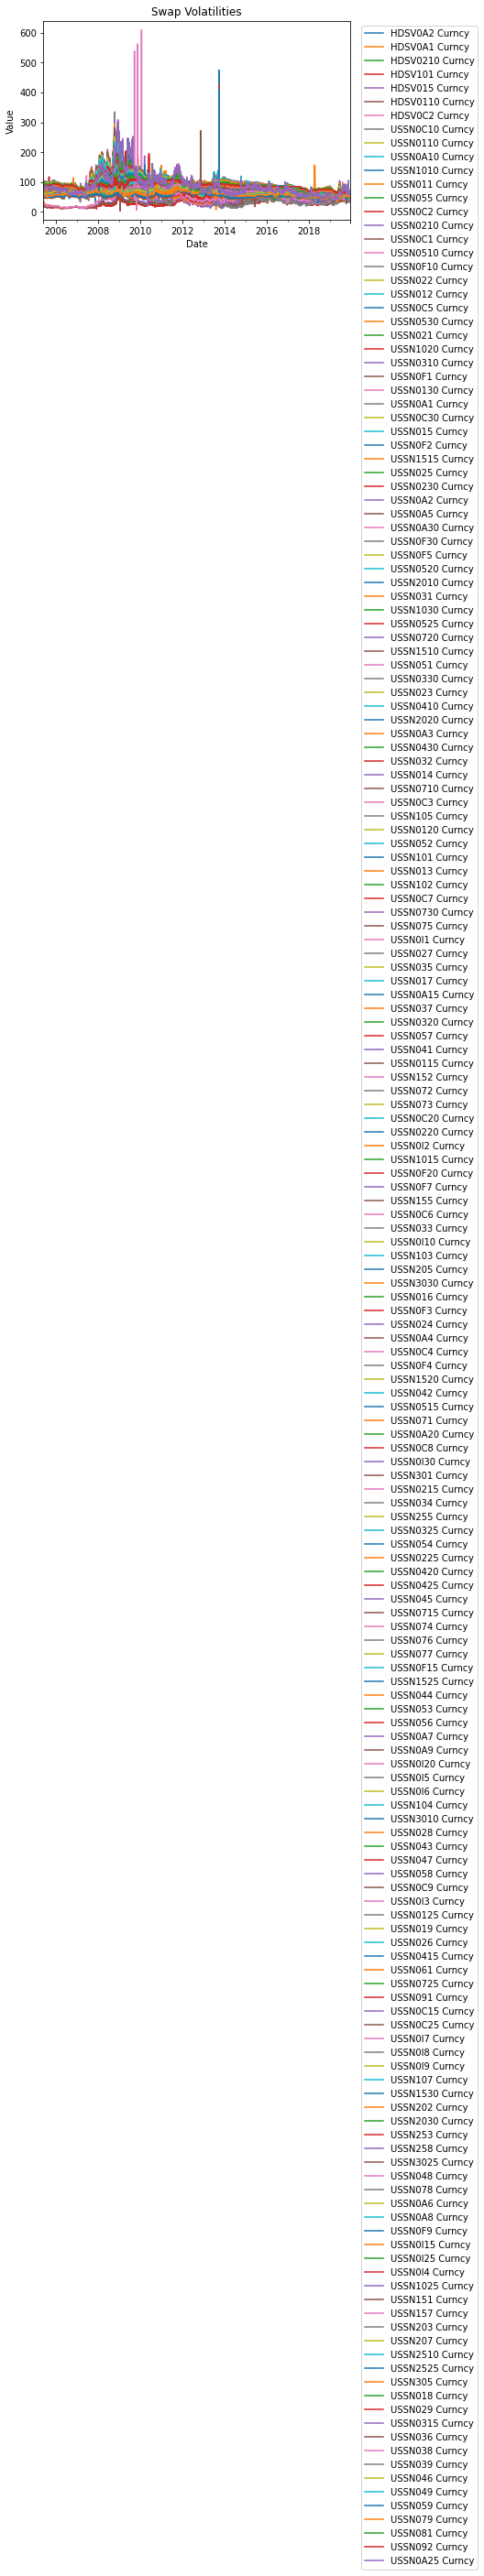

In [7]:
df = pd.read_excel('HKSwap2.xlsx', parse_dates=[0]) 
print(df.head())
#df = pd.read_excel('USInterestRate.xlsx', parse_dates=['Date'])

# Set the index of the DataFrame to the date column
df.set_index('Date', inplace=True)

# Plot the DataFrame using Matplotlib
df.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Swap Volatilities')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

In [8]:
import matplotlib.pyplot as plt

- We normalize the data between zero and one.  
- It does no harm to the linear estimation since we do a linear transformation
- It saves a lot of time and speeds up convergence in nonlinear estimation
- We can also standarize the data or do a normalization in the interval [-1,1]
- You can check if alternative normalization makes any difference
- We use the MinMaxScaler below for (0,1) but you can change it to (-1,1)

In [13]:
X = df.iloc[:, 1:].values
Date = df.iloc[:,0].index
from sklearn.preprocessing import MinMaxScaler
# X_standardized is the standardized matrix
scaler = MinMaxScaler(feature_range=(0, 1))
X= scaler.fit_transform(X)
HK = X[:,:7]
USA = X[:,7:]

(3798, 7)
(3798, 177)


Text(0.5, 1.0, 'Hong Kong Swap Volatilities')

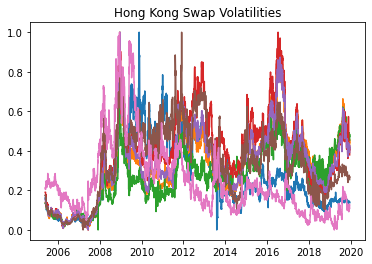

In [14]:
print(HK.shape)
print(USA.shape)
plt.plot(Date,HK) 
plt.title('Hong Kong Swap Volatilities')

Text(0.5, 1.0, 'USA Swap Option Volatilities')

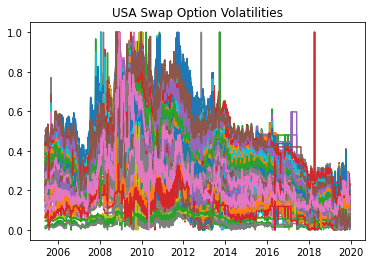

In [15]:
plt.plot(Date, USA)
plt.title('USA Swap Option Volatilities')

- We can see that the standard deviations are practically identical since the data are normalized.
- We import and use the PCA algorithm to examine the effectiveness for the first two principal components
- We do a scatter diagram to see that the two do not have a significant positive or negative correlation

In [24]:
Stats = np.std(HK,0)
StatsUS = np.std(USA,0)
print(np.max(Stats))
print(np.max(StatsUS))



0.20486869440186767
0.2032764279294758


In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
PC = pca.fit_transform(HK)

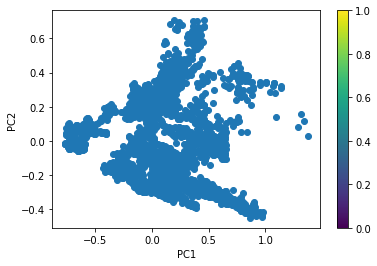

In [26]:
plt.scatter(PC[:,0], PC[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()


Text(0.5, 1.0, 'Principal Components for Hong Kong')

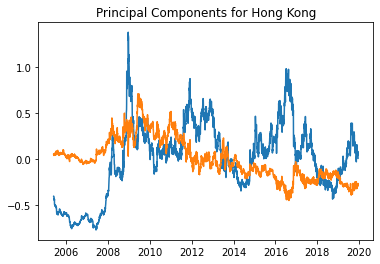

In [27]:
plt.plot(Date,PC)
plt.title('Principal Components for Hong Kong')

In [31]:
HKhat = pca.inverse_transform(PC)


Text(0.5, 1.0, 'Predicted Values for HK')

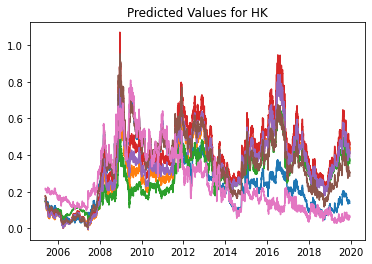

In [32]:
plt.plot(Date, HKhat)
plt.title('Predicted Values for HK')

78.66233725446511


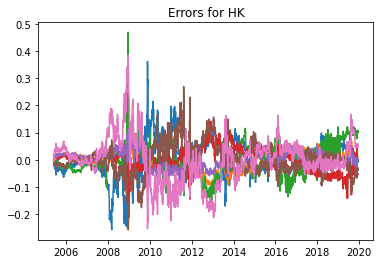

In [33]:
ERROR = HK - HKhat
plt.plot(Date,ERROR)
plt.title('Errors for HK')
SEE = np.sum(ERROR**2,axis=0)
SEE1 = np.sum(SEE)
print(SEE1)

In [36]:
variance_ratio = pca.explained_variance_ratio_
junk = np.var(HKhat,0)
junk1 = np.var(HK,0)
RSQ_PC_HK = junk/junk1
print(RSQ_PC_HK)
print(np.min(RSQ_PC_HK))
# Calculate the total percentage of the variance captured by the first two principal components
total_variance = np.sum(variance_ratio[:2])
percent_total_variance = total_variance * 100

print(f'The first two principal components explain {percent_total_variance:.2f} of the total variance')





[0.85894373 0.96162456 0.84353158 0.95964647 0.97622294 0.91419614
 0.80602972]
0.8060297201310861
The first two principal components explain 90.80 of the total variance


- We see that the PC has a minimum $R^2$ of .806 for some of the volatilities, others at .31.  So it does not have uniform good performance.

- Now lets try an autoencoder neural network
- Network structure is [20-10-2-10-20]
- Two layers of encoders and two layers of decoders

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load data into a NumPy array
# Define the dimensions of the input and latent spaces
input_dim = HK.shape[1]
latent_dim = 1

# Define the encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(100, activation='sigmoid')(inputs)
encoded = Dense(50, activation='sigmoid')(encoded)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(50, activation='sigmoid')(encoded)
decoded = Dense(100, activation='sigmoid')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Define the autoencoder
autoencoder = Model(inputs, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(HK, HK, epochs=10000)

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
encoded_HK = encoder.predict(HK)




Epoch 1/10000
119/119 [==============================] - 1s 784us/step - loss: 0.0781
Epoch 2/10000
119/119 [==============================] - 0s 776us/step - loss: 0.0322
Epoch 3/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0323
Epoch 4/10000
119/119 [==============================] - 0s 780us/step - loss: 0.0317
Epoch 5/10000
119/119 [==============================] - 0s 770us/step - loss: 0.0297
Epoch 6/10000
119/119 [==============================] - 0s 782us/step - loss: 0.0225
Epoch 7/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0122
Epoch 8/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0106
Epoch 9/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0103
Epoch 10/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0101
Epoch 11/10000
119/119 [==============================] - 0s 773us/step - loss: 0.0096
Epoch 12/10000
119/119 [============================

119/119 [==============================] - 0s 792us/step - loss: 0.0020
Epoch 96/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0020
Epoch 97/10000
119/119 [==============================] - 0s 747us/step - loss: 0.0020
Epoch 98/10000
119/119 [==============================] - 0s 746us/step - loss: 0.0020
Epoch 99/10000
119/119 [==============================] - 0s 747us/step - loss: 0.0020
Epoch 100/10000
119/119 [==============================] - 0s 757us/step - loss: 0.0020
Epoch 101/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0020
Epoch 102/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0019
Epoch 103/10000
119/119 [==============================] - 0s 707us/step - loss: 0.0019
Epoch 104/10000
119/119 [==============================] - 0s 726us/step - loss: 0.0019
Epoch 105/10000
119/119 [==============================] - 0s 729us/step - loss: 0.0019
Epoch 106/10000
119/119 [===========================

119/119 [==============================] - 0s 761us/step - loss: 0.0015
Epoch 189/10000
119/119 [==============================] - 0s 749us/step - loss: 0.0015
Epoch 190/10000
119/119 [==============================] - 0s 762us/step - loss: 0.0015
Epoch 191/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0015
Epoch 192/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0015
Epoch 193/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0015
Epoch 194/10000
119/119 [==============================] - 0s 787us/step - loss: 0.0015
Epoch 195/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0015
Epoch 196/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0015
Epoch 197/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0015
Epoch 198/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0015
Epoch 199/10000
119/119 [=======================

119/119 [==============================] - 0s 756us/step - loss: 0.0014
Epoch 282/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0014
Epoch 283/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0014
Epoch 284/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0014
Epoch 285/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0014
Epoch 286/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0014
Epoch 287/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0014
Epoch 288/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0014
Epoch 289/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0014
Epoch 290/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0014
Epoch 291/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0014
Epoch 292/10000
119/119 [=======================

119/119 [==============================] - 0s 753us/step - loss: 0.0013
Epoch 375/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0013
Epoch 376/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0013
Epoch 377/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0013
Epoch 378/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0013
Epoch 379/10000
119/119 [==============================] - 0s 776us/step - loss: 0.0013
Epoch 380/10000
119/119 [==============================] - 0s 768us/step - loss: 0.0013
Epoch 381/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0013
Epoch 382/10000
119/119 [==============================] - 0s 772us/step - loss: 0.0013
Epoch 383/10000
119/119 [==============================] - 0s 755us/step - loss: 0.0013
Epoch 384/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0013
Epoch 385/10000
119/119 [=======================

119/119 [==============================] - 0s 748us/step - loss: 0.0012
Epoch 468/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0012
Epoch 469/10000
119/119 [==============================] - 0s 739us/step - loss: 0.0012
Epoch 470/10000
119/119 [==============================] - 0s 740us/step - loss: 0.0012
Epoch 471/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0012
Epoch 472/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0012
Epoch 473/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0012
Epoch 474/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0012
Epoch 475/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0012
Epoch 476/10000
119/119 [==============================] - 0s 744us/step - loss: 0.0011
Epoch 477/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 478/10000
119/119 [=======================

119/119 [==============================] - 0s 757us/step - loss: 0.0011
Epoch 561/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 562/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 563/10000
119/119 [==============================] - 0s 747us/step - loss: 0.0011
Epoch 564/10000
119/119 [==============================] - 0s 746us/step - loss: 0.0010
Epoch 565/10000
119/119 [==============================] - 0s 772us/step - loss: 0.0011
Epoch 566/10000
119/119 [==============================] - 0s 746us/step - loss: 0.0011
Epoch 567/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0011
Epoch 568/10000
119/119 [==============================] - 0s 771us/step - loss: 0.0011
Epoch 569/10000
119/119 [==============================] - 0s 742us/step - loss: 0.0010
Epoch 570/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0011
Epoch 571/10000
119/119 [=======================

119/119 [==============================] - 0s 753us/step - loss: 9.8855e-04
Epoch 654/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0010
Epoch 655/10000
119/119 [==============================] - 0s 745us/step - loss: 9.9113e-04
Epoch 656/10000
119/119 [==============================] - 0s 751us/step - loss: 9.9666e-04
Epoch 657/10000
119/119 [==============================] - 0s 751us/step - loss: 9.9628e-04
Epoch 658/10000
119/119 [==============================] - 0s 751us/step - loss: 9.9253e-04
Epoch 659/10000
119/119 [==============================] - 0s 751us/step - loss: 9.9686e-04
Epoch 660/10000
119/119 [==============================] - 0s 747us/step - loss: 9.7656e-04
Epoch 661/10000
119/119 [==============================] - 0s 757us/step - loss: 0.0010
Epoch 662/10000
119/119 [==============================] - 0s 762us/step - loss: 9.8438e-04
Epoch 663/10000
119/119 [==============================] - 0s 799us/step - loss: 9.9291e-04
Epoch 664/10

119/119 [==============================] - 0s 764us/step - loss: 9.5646e-04
Epoch 743/10000
119/119 [==============================] - 0s 750us/step - loss: 9.3075e-04
Epoch 744/10000
119/119 [==============================] - 0s 748us/step - loss: 9.4550e-04
Epoch 745/10000
119/119 [==============================] - 0s 747us/step - loss: 9.4167e-04
Epoch 746/10000
119/119 [==============================] - 0s 737us/step - loss: 9.3412e-04
Epoch 747/10000
119/119 [==============================] - 0s 756us/step - loss: 9.5846e-04
Epoch 748/10000
119/119 [==============================] - 0s 746us/step - loss: 9.3759e-04
Epoch 749/10000
119/119 [==============================] - 0s 747us/step - loss: 9.5197e-04
Epoch 750/10000
119/119 [==============================] - 0s 748us/step - loss: 9.2780e-04
Epoch 751/10000
119/119 [==============================] - 0s 748us/step - loss: 9.4499e-04
Epoch 752/10000
119/119 [==============================] - 0s 748us/step - loss: 9.3349e-04
Epoc

119/119 [==============================] - 0s 753us/step - loss: 9.1737e-04
Epoch 832/10000
119/119 [==============================] - 0s 745us/step - loss: 9.2124e-04
Epoch 833/10000
119/119 [==============================] - 0s 750us/step - loss: 9.0074e-04
Epoch 834/10000
119/119 [==============================] - 0s 755us/step - loss: 8.8546e-04
Epoch 835/10000
119/119 [==============================] - 0s 746us/step - loss: 9.0801e-04
Epoch 836/10000
119/119 [==============================] - 0s 746us/step - loss: 8.9359e-04
Epoch 837/10000
119/119 [==============================] - 0s 747us/step - loss: 9.0769e-04
Epoch 838/10000
119/119 [==============================] - 0s 747us/step - loss: 9.1628e-04
Epoch 839/10000
119/119 [==============================] - 0s 752us/step - loss: 8.9562e-04
Epoch 840/10000
119/119 [==============================] - 0s 760us/step - loss: 8.9132e-04
Epoch 841/10000
119/119 [==============================] - 0s 751us/step - loss: 9.0249e-04
Epoc

119/119 [==============================] - 0s 742us/step - loss: 8.7577e-04
Epoch 921/10000
119/119 [==============================] - 0s 742us/step - loss: 8.7124e-04
Epoch 922/10000
119/119 [==============================] - 0s 736us/step - loss: 8.8579e-04
Epoch 923/10000
119/119 [==============================] - 0s 748us/step - loss: 8.8400e-04
Epoch 924/10000
119/119 [==============================] - 0s 762us/step - loss: 8.8038e-04
Epoch 925/10000
119/119 [==============================] - 0s 745us/step - loss: 8.6944e-04
Epoch 926/10000
119/119 [==============================] - 0s 748us/step - loss: 8.7814e-04
Epoch 927/10000
119/119 [==============================] - 0s 742us/step - loss: 8.7012e-04
Epoch 928/10000
119/119 [==============================] - 0s 742us/step - loss: 8.7380e-04
Epoch 929/10000
119/119 [==============================] - 0s 747us/step - loss: 8.8906e-04
Epoch 930/10000
119/119 [==============================] - 0s 748us/step - loss: 8.7481e-04
Epoc

119/119 [==============================] - 0s 744us/step - loss: 8.3043e-04
Epoch 1010/10000
119/119 [==============================] - 0s 769us/step - loss: 8.4204e-04
Epoch 1011/10000
119/119 [==============================] - 0s 761us/step - loss: 8.3713e-04
Epoch 1012/10000
119/119 [==============================] - 0s 761us/step - loss: 8.3679e-04
Epoch 1013/10000
119/119 [==============================] - 0s 761us/step - loss: 8.3124e-04
Epoch 1014/10000
119/119 [==============================] - 0s 761us/step - loss: 8.4271e-04
Epoch 1015/10000
119/119 [==============================] - 0s 764us/step - loss: 8.3941e-04
Epoch 1016/10000
119/119 [==============================] - 0s 752us/step - loss: 8.3580e-04
Epoch 1017/10000
119/119 [==============================] - 0s 761us/step - loss: 8.5480e-04
Epoch 1018/10000
119/119 [==============================] - 0s 769us/step - loss: 8.4062e-04
Epoch 1019/10000
119/119 [==============================] - 0s 761us/step - loss: 8.577

119/119 [==============================] - 0s 756us/step - loss: 8.1036e-04
Epoch 1098/10000
119/119 [==============================] - 0s 772us/step - loss: 7.9960e-04
Epoch 1099/10000
119/119 [==============================] - 0s 747us/step - loss: 8.0963e-04
Epoch 1100/10000
119/119 [==============================] - 0s 762us/step - loss: 8.0329e-04
Epoch 1101/10000
119/119 [==============================] - 0s 773us/step - loss: 8.1745e-04
Epoch 1102/10000
119/119 [==============================] - 0s 771us/step - loss: 8.0093e-04
Epoch 1103/10000
119/119 [==============================] - 0s 790us/step - loss: 8.0611e-04
Epoch 1104/10000
119/119 [==============================] - 0s 771us/step - loss: 8.0329e-04
Epoch 1105/10000
119/119 [==============================] - 0s 754us/step - loss: 7.9145e-04
Epoch 1106/10000
119/119 [==============================] - 0s 765us/step - loss: 8.1560e-04
Epoch 1107/10000
119/119 [==============================] - 0s 754us/step - loss: 8.091

119/119 [==============================] - 0s 745us/step - loss: 7.7487e-04
Epoch 1186/10000
119/119 [==============================] - 0s 756us/step - loss: 7.7305e-04
Epoch 1187/10000
119/119 [==============================] - 0s 754us/step - loss: 7.8036e-04
Epoch 1188/10000
119/119 [==============================] - 0s 756us/step - loss: 7.7903e-04
Epoch 1189/10000
119/119 [==============================] - 0s 762us/step - loss: 7.8541e-04
Epoch 1190/10000
119/119 [==============================] - 0s 756us/step - loss: 7.6563e-04
Epoch 1191/10000
119/119 [==============================] - 0s 745us/step - loss: 7.7496e-04
Epoch 1192/10000
119/119 [==============================] - 0s 755us/step - loss: 7.7398e-04
Epoch 1193/10000
119/119 [==============================] - 0s 806us/step - loss: 7.8747e-04
Epoch 1194/10000
119/119 [==============================] - 0s 756us/step - loss: 7.8140e-04
Epoch 1195/10000
119/119 [==============================] - 0s 754us/step - loss: 7.773

119/119 [==============================] - 0s 770us/step - loss: 7.5454e-04
Epoch 1274/10000
119/119 [==============================] - 0s 765us/step - loss: 7.5714e-04
Epoch 1275/10000
119/119 [==============================] - 0s 802us/step - loss: 7.6893e-04
Epoch 1276/10000
119/119 [==============================] - 0s 781us/step - loss: 7.6416e-04
Epoch 1277/10000
119/119 [==============================] - 0s 748us/step - loss: 7.5621e-04
Epoch 1278/10000
119/119 [==============================] - 0s 830us/step - loss: 7.5256e-04
Epoch 1279/10000
119/119 [==============================] - 0s 838us/step - loss: 7.8270e-04
Epoch 1280/10000
119/119 [==============================] - 0s 870us/step - loss: 7.6080e-04
Epoch 1281/10000
119/119 [==============================] - 0s 848us/step - loss: 7.5344e-04
Epoch 1282/10000
119/119 [==============================] - 0s 846us/step - loss: 7.5905e-04
Epoch 1283/10000
119/119 [==============================] - 0s 847us/step - loss: 7.592

119/119 [==============================] - 0s 762us/step - loss: 7.3815e-04
Epoch 1362/10000
119/119 [==============================] - 0s 748us/step - loss: 7.4814e-04
Epoch 1363/10000
119/119 [==============================] - 0s 763us/step - loss: 7.4345e-04
Epoch 1364/10000
119/119 [==============================] - 0s 750us/step - loss: 7.3836e-04
Epoch 1365/10000
119/119 [==============================] - 0s 759us/step - loss: 7.5230e-04
Epoch 1366/10000
119/119 [==============================] - 0s 751us/step - loss: 7.4027e-04
Epoch 1367/10000
119/119 [==============================] - 0s 768us/step - loss: 7.4649e-04
Epoch 1368/10000
119/119 [==============================] - 0s 750us/step - loss: 7.6645e-04
Epoch 1369/10000
119/119 [==============================] - 0s 760us/step - loss: 7.2691e-04
Epoch 1370/10000
119/119 [==============================] - 0s 764us/step - loss: 7.4775e-04
Epoch 1371/10000
119/119 [==============================] - 0s 763us/step - loss: 7.236

119/119 [==============================] - 0s 756us/step - loss: 7.3139e-04
Epoch 1450/10000
119/119 [==============================] - 0s 779us/step - loss: 7.2559e-04
Epoch 1451/10000
119/119 [==============================] - 0s 773us/step - loss: 7.2871e-04
Epoch 1452/10000
119/119 [==============================] - 0s 737us/step - loss: 7.3847e-04
Epoch 1453/10000
119/119 [==============================] - 0s 748us/step - loss: 7.3827e-04
Epoch 1454/10000
119/119 [==============================] - 0s 746us/step - loss: 7.3882e-04
Epoch 1455/10000
119/119 [==============================] - 0s 747us/step - loss: 7.2317e-04
Epoch 1456/10000
119/119 [==============================] - 0s 762us/step - loss: 7.2576e-04
Epoch 1457/10000
119/119 [==============================] - 0s 748us/step - loss: 7.2661e-04
Epoch 1458/10000
119/119 [==============================] - 0s 745us/step - loss: 7.3965e-04
Epoch 1459/10000
119/119 [==============================] - 0s 739us/step - loss: 7.224

119/119 [==============================] - 0s 771us/step - loss: 7.0950e-04
Epoch 1538/10000
119/119 [==============================] - 0s 744us/step - loss: 7.1927e-04
Epoch 1539/10000
119/119 [==============================] - 0s 765us/step - loss: 7.1426e-04
Epoch 1540/10000
119/119 [==============================] - 0s 744us/step - loss: 7.3362e-04
Epoch 1541/10000
119/119 [==============================] - 0s 751us/step - loss: 7.0387e-04
Epoch 1542/10000
119/119 [==============================] - 0s 760us/step - loss: 7.1794e-04
Epoch 1543/10000
119/119 [==============================] - 0s 747us/step - loss: 7.1115e-04
Epoch 1544/10000
119/119 [==============================] - 0s 766us/step - loss: 7.1598e-04
Epoch 1545/10000
119/119 [==============================] - 0s 770us/step - loss: 7.1277e-04
Epoch 1546/10000
119/119 [==============================] - 0s 756us/step - loss: 7.1806e-04
Epoch 1547/10000
119/119 [==============================] - 0s 765us/step - loss: 7.168

119/119 [==============================] - 0s 745us/step - loss: 6.9784e-04
Epoch 1626/10000
119/119 [==============================] - 0s 748us/step - loss: 6.9371e-04
Epoch 1627/10000
119/119 [==============================] - 0s 745us/step - loss: 7.0075e-04
Epoch 1628/10000
119/119 [==============================] - 0s 745us/step - loss: 7.1864e-04
Epoch 1629/10000
119/119 [==============================] - 0s 740us/step - loss: 7.1394e-04
Epoch 1630/10000
119/119 [==============================] - 0s 751us/step - loss: 7.0689e-04
Epoch 1631/10000
119/119 [==============================] - 0s 742us/step - loss: 6.9624e-04
Epoch 1632/10000
119/119 [==============================] - 0s 747us/step - loss: 7.0609e-04
Epoch 1633/10000
119/119 [==============================] - 0s 748us/step - loss: 7.1421e-04
Epoch 1634/10000
119/119 [==============================] - 0s 753us/step - loss: 6.9888e-04
Epoch 1635/10000
119/119 [==============================] - 0s 740us/step - loss: 6.979

119/119 [==============================] - 0s 745us/step - loss: 6.8739e-04
Epoch 1714/10000
119/119 [==============================] - 0s 748us/step - loss: 6.9468e-04
Epoch 1715/10000
119/119 [==============================] - 0s 737us/step - loss: 6.8385e-04
Epoch 1716/10000
119/119 [==============================] - 0s 748us/step - loss: 6.9539e-04
Epoch 1717/10000
119/119 [==============================] - 0s 737us/step - loss: 6.8093e-04
Epoch 1718/10000
119/119 [==============================] - 0s 748us/step - loss: 6.8331e-04
Epoch 1719/10000
119/119 [==============================] - 0s 748us/step - loss: 6.8163e-04
Epoch 1720/10000
119/119 [==============================] - 0s 745us/step - loss: 6.8620e-04
Epoch 1721/10000
119/119 [==============================] - 0s 748us/step - loss: 6.8285e-04
Epoch 1722/10000
119/119 [==============================] - 0s 737us/step - loss: 6.7530e-04
Epoch 1723/10000
119/119 [==============================] - 0s 759us/step - loss: 6.928

119/119 [==============================] - 0s 765us/step - loss: 6.7297e-04
Epoch 1802/10000
119/119 [==============================] - 0s 744us/step - loss: 6.7857e-04
Epoch 1803/10000
119/119 [==============================] - 0s 749us/step - loss: 6.8306e-04
Epoch 1804/10000
119/119 [==============================] - 0s 742us/step - loss: 6.6887e-04
Epoch 1805/10000
119/119 [==============================] - 0s 742us/step - loss: 6.5965e-04
Epoch 1806/10000
119/119 [==============================] - 0s 747us/step - loss: 6.6737e-04
Epoch 1807/10000
119/119 [==============================] - 0s 754us/step - loss: 6.6645e-04
Epoch 1808/10000
119/119 [==============================] - 0s 798us/step - loss: 6.6234e-04
Epoch 1809/10000
119/119 [==============================] - 0s 754us/step - loss: 6.7330e-04
Epoch 1810/10000
119/119 [==============================] - 0s 748us/step - loss: 6.7867e-04
Epoch 1811/10000
119/119 [==============================] - 0s 754us/step - loss: 6.671

119/119 [==============================] - 0s 754us/step - loss: 6.6066e-04
Epoch 1890/10000
119/119 [==============================] - 0s 748us/step - loss: 6.6232e-04
Epoch 1891/10000
119/119 [==============================] - 0s 762us/step - loss: 6.5369e-04
Epoch 1892/10000
119/119 [==============================] - 0s 739us/step - loss: 6.4799e-04
Epoch 1893/10000
119/119 [==============================] - 0s 745us/step - loss: 6.6256e-04
Epoch 1894/10000
119/119 [==============================] - 0s 739us/step - loss: 6.6237e-04
Epoch 1895/10000
119/119 [==============================] - 0s 748us/step - loss: 6.6450e-04
Epoch 1896/10000
119/119 [==============================] - 0s 737us/step - loss: 6.4925e-04
Epoch 1897/10000
119/119 [==============================] - 0s 748us/step - loss: 6.4720e-04
Epoch 1898/10000
119/119 [==============================] - 0s 745us/step - loss: 6.6251e-04
Epoch 1899/10000
119/119 [==============================] - 0s 748us/step - loss: 6.562

119/119 [==============================] - 0s 751us/step - loss: 6.3848e-04
Epoch 1978/10000
119/119 [==============================] - 0s 751us/step - loss: 6.4963e-04
Epoch 1979/10000
119/119 [==============================] - 0s 745us/step - loss: 6.4677e-04
Epoch 1980/10000
119/119 [==============================] - 0s 748us/step - loss: 6.3612e-04
Epoch 1981/10000
119/119 [==============================] - 0s 747us/step - loss: 6.3933e-04
Epoch 1982/10000
119/119 [==============================] - 0s 745us/step - loss: 6.4080e-04
Epoch 1983/10000
119/119 [==============================] - 0s 748us/step - loss: 6.4623e-04
Epoch 1984/10000
119/119 [==============================] - 0s 756us/step - loss: 6.4422e-04
Epoch 1985/10000
119/119 [==============================] - 0s 735us/step - loss: 6.3925e-04
Epoch 1986/10000
119/119 [==============================] - 0s 756us/step - loss: 6.3428e-04
Epoch 1987/10000
119/119 [==============================] - 0s 748us/step - loss: 6.358

119/119 [==============================] - 0s 754us/step - loss: 6.2868e-04
Epoch 2066/10000
119/119 [==============================] - 0s 748us/step - loss: 6.3372e-04
Epoch 2067/10000
119/119 [==============================] - 0s 748us/step - loss: 6.2369e-04
Epoch 2068/10000
119/119 [==============================] - 0s 745us/step - loss: 6.2981e-04
Epoch 2069/10000
119/119 [==============================] - 0s 739us/step - loss: 6.4415e-04
Epoch 2070/10000
119/119 [==============================] - 0s 762us/step - loss: 6.2133e-04
Epoch 2071/10000
119/119 [==============================] - 0s 748us/step - loss: 6.3368e-04
Epoch 2072/10000
119/119 [==============================] - 0s 748us/step - loss: 6.3875e-04
Epoch 2073/10000
119/119 [==============================] - 0s 745us/step - loss: 6.2471e-04
Epoch 2074/10000
119/119 [==============================] - 0s 748us/step - loss: 6.3358e-04
Epoch 2075/10000
119/119 [==============================] - 0s 754us/step - loss: 6.299

119/119 [==============================] - 0s 749us/step - loss: 6.2063e-04
Epoch 2154/10000
119/119 [==============================] - 0s 762us/step - loss: 6.1795e-04
Epoch 2155/10000
119/119 [==============================] - 0s 748us/step - loss: 6.2504e-04
Epoch 2156/10000
119/119 [==============================] - 0s 748us/step - loss: 6.0867e-04
Epoch 2157/10000
119/119 [==============================] - 0s 748us/step - loss: 6.2370e-04
Epoch 2158/10000
119/119 [==============================] - 0s 745us/step - loss: 6.1517e-04
Epoch 2159/10000
119/119 [==============================] - 0s 757us/step - loss: 6.1866e-04
Epoch 2160/10000
119/119 [==============================] - 0s 753us/step - loss: 6.2316e-04
Epoch 2161/10000
119/119 [==============================] - 0s 737us/step - loss: 6.2372e-04
Epoch 2162/10000
119/119 [==============================] - 0s 750us/step - loss: 6.2693e-04
Epoch 2163/10000
119/119 [==============================] - 0s 745us/step - loss: 6.178

119/119 [==============================] - 0s 756us/step - loss: 6.0550e-04
Epoch 2242/10000
119/119 [==============================] - 0s 754us/step - loss: 6.1909e-04
Epoch 2243/10000
119/119 [==============================] - 0s 751us/step - loss: 6.1713e-04
Epoch 2244/10000
119/119 [==============================] - 0s 759us/step - loss: 5.9583e-04
Epoch 2245/10000
119/119 [==============================] - 0s 769us/step - loss: 6.1366e-04
Epoch 2246/10000
119/119 [==============================] - 0s 750us/step - loss: 6.0682e-04
Epoch 2247/10000
119/119 [==============================] - 0s 764us/step - loss: 5.9725e-04
Epoch 2248/10000
119/119 [==============================] - 0s 763us/step - loss: 6.0857e-04
Epoch 2249/10000
119/119 [==============================] - 0s 764us/step - loss: 6.1293e-04
Epoch 2250/10000
119/119 [==============================] - 0s 763us/step - loss: 6.1036e-04
Epoch 2251/10000
119/119 [==============================] - 0s 756us/step - loss: 6.038

119/119 [==============================] - 0s 786us/step - loss: 6.0254e-04
Epoch 2330/10000
119/119 [==============================] - 0s 752us/step - loss: 5.9892e-04
Epoch 2331/10000
119/119 [==============================] - 0s 756us/step - loss: 5.9691e-04
Epoch 2332/10000
119/119 [==============================] - 0s 753us/step - loss: 5.9475e-04
Epoch 2333/10000
119/119 [==============================] - 0s 752us/step - loss: 5.9306e-04
Epoch 2334/10000
119/119 [==============================] - 0s 744us/step - loss: 5.9950e-04
Epoch 2335/10000
119/119 [==============================] - 0s 744us/step - loss: 5.9795e-04
Epoch 2336/10000
119/119 [==============================] - 0s 769us/step - loss: 6.0193e-04
Epoch 2337/10000
119/119 [==============================] - 0s 761us/step - loss: 5.9341e-04
Epoch 2338/10000
119/119 [==============================] - 0s 744us/step - loss: 5.9598e-04
Epoch 2339/10000
119/119 [==============================] - 0s 769us/step - loss: 5.995

119/119 [==============================] - 0s 743us/step - loss: 5.8828e-04
Epoch 2418/10000
119/119 [==============================] - 0s 748us/step - loss: 5.8949e-04
Epoch 2419/10000
119/119 [==============================] - 0s 748us/step - loss: 5.9396e-04
Epoch 2420/10000
119/119 [==============================] - 0s 745us/step - loss: 5.8453e-04
Epoch 2421/10000
119/119 [==============================] - 0s 748us/step - loss: 5.9826e-04
Epoch 2422/10000
119/119 [==============================] - 0s 748us/step - loss: 5.8660e-04
Epoch 2423/10000
119/119 [==============================] - 0s 748us/step - loss: 5.8970e-04
Epoch 2424/10000
119/119 [==============================] - 0s 739us/step - loss: 5.9003e-04
Epoch 2425/10000
119/119 [==============================] - 0s 734us/step - loss: 5.8888e-04
Epoch 2426/10000
119/119 [==============================] - 0s 756us/step - loss: 5.9327e-04
Epoch 2427/10000
119/119 [==============================] - 0s 748us/step - loss: 5.853

119/119 [==============================] - 0s 745us/step - loss: 5.7602e-04
Epoch 2506/10000
119/119 [==============================] - 0s 748us/step - loss: 5.8022e-04
Epoch 2507/10000
119/119 [==============================] - 0s 756us/step - loss: 5.7972e-04
Epoch 2508/10000
119/119 [==============================] - 0s 745us/step - loss: 5.8383e-04
Epoch 2509/10000
119/119 [==============================] - 0s 756us/step - loss: 5.8222e-04
Epoch 2510/10000
119/119 [==============================] - 0s 745us/step - loss: 5.8576e-04
Epoch 2511/10000
119/119 [==============================] - 0s 756us/step - loss: 5.8917e-04
Epoch 2512/10000
119/119 [==============================] - 0s 745us/step - loss: 5.9140e-04
Epoch 2513/10000
119/119 [==============================] - 0s 748us/step - loss: 5.9853e-04
Epoch 2514/10000
119/119 [==============================] - 0s 739us/step - loss: 5.8205e-04
Epoch 2515/10000
119/119 [==============================] - 0s 745us/step - loss: 5.818

119/119 [==============================] - 0s 791us/step - loss: 5.7117e-04
Epoch 2594/10000
119/119 [==============================] - 0s 753us/step - loss: 5.7224e-04
Epoch 2595/10000
119/119 [==============================] - 0s 754us/step - loss: 5.7300e-04
Epoch 2596/10000
119/119 [==============================] - 0s 748us/step - loss: 5.8460e-04
Epoch 2597/10000
119/119 [==============================] - 0s 748us/step - loss: 5.7878e-04
Epoch 2598/10000
119/119 [==============================] - 0s 754us/step - loss: 5.7111e-04
Epoch 2599/10000
119/119 [==============================] - 0s 748us/step - loss: 5.8242e-04
Epoch 2600/10000
119/119 [==============================] - 0s 796us/step - loss: 5.7020e-04
Epoch 2601/10000
119/119 [==============================] - 0s 751us/step - loss: 5.7968e-04
Epoch 2602/10000
119/119 [==============================] - 0s 734us/step - loss: 5.7035e-04
Epoch 2603/10000
119/119 [==============================] - 0s 751us/step - loss: 5.806

119/119 [==============================] - 0s 754us/step - loss: 5.6907e-04
Epoch 2682/10000
119/119 [==============================] - 0s 751us/step - loss: 5.7407e-04
Epoch 2683/10000
119/119 [==============================] - 0s 753us/step - loss: 5.6267e-04
Epoch 2684/10000
119/119 [==============================] - 0s 748us/step - loss: 5.6452e-04
Epoch 2685/10000
119/119 [==============================] - 0s 745us/step - loss: 5.7626e-04
Epoch 2686/10000
119/119 [==============================] - 0s 745us/step - loss: 5.6614e-04
Epoch 2687/10000
119/119 [==============================] - 0s 740us/step - loss: 5.7103e-04
Epoch 2688/10000
119/119 [==============================] - 0s 753us/step - loss: 5.6653e-04
Epoch 2689/10000
119/119 [==============================] - 0s 748us/step - loss: 5.6213e-04
Epoch 2690/10000
119/119 [==============================] - 0s 742us/step - loss: 5.6179e-04
Epoch 2691/10000
119/119 [==============================] - 0s 759us/step - loss: 5.681

119/119 [==============================] - 0s 753us/step - loss: 5.6396e-04
Epoch 2770/10000
119/119 [==============================] - 0s 756us/step - loss: 5.5912e-04
Epoch 2771/10000
119/119 [==============================] - 0s 745us/step - loss: 5.6099e-04
Epoch 2772/10000
119/119 [==============================] - 0s 753us/step - loss: 5.5705e-04
Epoch 2773/10000
119/119 [==============================] - 0s 748us/step - loss: 5.5720e-04
Epoch 2774/10000
119/119 [==============================] - 0s 756us/step - loss: 5.5536e-04
Epoch 2775/10000
119/119 [==============================] - 0s 746us/step - loss: 5.6631e-04
Epoch 2776/10000
119/119 [==============================] - 0s 747us/step - loss: 5.6691e-04
Epoch 2777/10000
119/119 [==============================] - 0s 746us/step - loss: 5.6084e-04
Epoch 2778/10000
119/119 [==============================] - 0s 756us/step - loss: 5.6177e-04
Epoch 2779/10000
119/119 [==============================] - 0s 757us/step - loss: 5.617

119/119 [==============================] - 0s 748us/step - loss: 5.5353e-04
Epoch 2858/10000
119/119 [==============================] - 0s 745us/step - loss: 5.5934e-04
Epoch 2859/10000
119/119 [==============================] - 0s 753us/step - loss: 5.4906e-04
Epoch 2860/10000
119/119 [==============================] - 0s 748us/step - loss: 5.6371e-04
Epoch 2861/10000
119/119 [==============================] - 0s 745us/step - loss: 5.4729e-04
Epoch 2862/10000
119/119 [==============================] - 0s 748us/step - loss: 5.5269e-04
Epoch 2863/10000
119/119 [==============================] - 0s 765us/step - loss: 5.5369e-04
Epoch 2864/10000
119/119 [==============================] - 0s 745us/step - loss: 5.5246e-04
Epoch 2865/10000
119/119 [==============================] - 0s 756us/step - loss: 5.4907e-04
Epoch 2866/10000
119/119 [==============================] - 0s 737us/step - loss: 5.5116e-04
Epoch 2867/10000
119/119 [==============================] - 0s 748us/step - loss: 5.648

119/119 [==============================] - 0s 774us/step - loss: 5.5666e-04
Epoch 2946/10000
119/119 [==============================] - 0s 795us/step - loss: 5.5589e-04
Epoch 2947/10000
119/119 [==============================] - 0s 754us/step - loss: 5.5639e-04
Epoch 2948/10000
119/119 [==============================] - 0s 756us/step - loss: 5.5435e-04
Epoch 2949/10000
119/119 [==============================] - 0s 737us/step - loss: 5.4471e-04
Epoch 2950/10000
119/119 [==============================] - 0s 752us/step - loss: 5.4915e-04
Epoch 2951/10000
119/119 [==============================] - 0s 744us/step - loss: 5.4641e-04
Epoch 2952/10000
119/119 [==============================] - 0s 749us/step - loss: 5.5070e-04
Epoch 2953/10000
119/119 [==============================] - 0s 755us/step - loss: 5.4484e-04
Epoch 2954/10000
119/119 [==============================] - 0s 763us/step - loss: 5.4909e-04
Epoch 2955/10000
119/119 [==============================] - 0s 745us/step - loss: 5.481

119/119 [==============================] - 0s 754us/step - loss: 5.3907e-04
Epoch 3034/10000
119/119 [==============================] - 0s 739us/step - loss: 5.4815e-04
Epoch 3035/10000
119/119 [==============================] - 0s 765us/step - loss: 5.3981e-04
Epoch 3036/10000
119/119 [==============================] - 0s 745us/step - loss: 5.4481e-04
Epoch 3037/10000
119/119 [==============================] - 0s 748us/step - loss: 5.4842e-04
Epoch 3038/10000
119/119 [==============================] - 0s 745us/step - loss: 5.3737e-04
Epoch 3039/10000
119/119 [==============================] - 0s 768us/step - loss: 5.4514e-04
Epoch 3040/10000
119/119 [==============================] - 0s 751us/step - loss: 5.4609e-04
Epoch 3041/10000
119/119 [==============================] - 0s 748us/step - loss: 5.3578e-04
Epoch 3042/10000
119/119 [==============================] - 0s 745us/step - loss: 5.4923e-04
Epoch 3043/10000
119/119 [==============================] - 0s 748us/step - loss: 5.438

119/119 [==============================] - 0s 779us/step - loss: 5.3086e-04
Epoch 3122/10000
119/119 [==============================] - 0s 765us/step - loss: 5.4068e-04
Epoch 3123/10000
119/119 [==============================] - 0s 770us/step - loss: 5.4212e-04
Epoch 3124/10000
119/119 [==============================] - 0s 782us/step - loss: 5.3927e-04
Epoch 3125/10000
119/119 [==============================] - 0s 779us/step - loss: 5.3323e-04
Epoch 3126/10000
119/119 [==============================] - 0s 791us/step - loss: 5.3284e-04
Epoch 3127/10000
119/119 [==============================] - 0s 804us/step - loss: 5.3607e-04
Epoch 3128/10000
119/119 [==============================] - 0s 772us/step - loss: 5.3314e-04
Epoch 3129/10000
119/119 [==============================] - 0s 778us/step - loss: 5.4274e-04
Epoch 3130/10000
119/119 [==============================] - 0s 765us/step - loss: 5.3425e-04
Epoch 3131/10000
119/119 [==============================] - 0s 762us/step - loss: 5.379

119/119 [==============================] - 0s 782us/step - loss: 5.3369e-04
Epoch 3210/10000
119/119 [==============================] - 0s 753us/step - loss: 5.2837e-04
Epoch 3211/10000
119/119 [==============================] - 0s 757us/step - loss: 5.2925e-04
Epoch 3212/10000
119/119 [==============================] - 0s 787us/step - loss: 5.4765e-04
Epoch 3213/10000
119/119 [==============================] - 0s 779us/step - loss: 5.3840e-04
Epoch 3214/10000
119/119 [==============================] - 0s 766us/step - loss: 5.3755e-04
Epoch 3215/10000
119/119 [==============================] - 0s 783us/step - loss: 5.3342e-04
Epoch 3216/10000
119/119 [==============================] - 0s 767us/step - loss: 5.3009e-04
Epoch 3217/10000
119/119 [==============================] - 0s 773us/step - loss: 5.3332e-04
Epoch 3218/10000
119/119 [==============================] - 0s 780us/step - loss: 5.3169e-04
Epoch 3219/10000
119/119 [==============================] - 0s 764us/step - loss: 5.441

119/119 [==============================] - 0s 754us/step - loss: 5.2723e-04
Epoch 3298/10000
119/119 [==============================] - 0s 753us/step - loss: 5.3016e-04
Epoch 3299/10000
119/119 [==============================] - 0s 748us/step - loss: 5.2915e-04
Epoch 3300/10000
119/119 [==============================] - 0s 751us/step - loss: 5.3953e-04
Epoch 3301/10000
119/119 [==============================] - 0s 759us/step - loss: 5.2379e-04
Epoch 3302/10000
119/119 [==============================] - 0s 756us/step - loss: 5.2628e-04
Epoch 3303/10000
119/119 [==============================] - 0s 797us/step - loss: 5.2818e-04
Epoch 3304/10000
119/119 [==============================] - 0s 762us/step - loss: 5.3518e-04
Epoch 3305/10000
119/119 [==============================] - 0s 756us/step - loss: 5.2747e-04
Epoch 3306/10000
119/119 [==============================] - 0s 762us/step - loss: 5.2795e-04
Epoch 3307/10000
119/119 [==============================] - 0s 765us/step - loss: 5.227

119/119 [==============================] - 0s 782us/step - loss: 5.3108e-04
Epoch 3386/10000
119/119 [==============================] - 0s 762us/step - loss: 5.2428e-04
Epoch 3387/10000
119/119 [==============================] - 0s 756us/step - loss: 5.1920e-04
Epoch 3388/10000
119/119 [==============================] - 0s 779us/step - loss: 5.2791e-04
Epoch 3389/10000
119/119 [==============================] - 0s 756us/step - loss: 5.2041e-04
Epoch 3390/10000
119/119 [==============================] - 0s 754us/step - loss: 5.1980e-04
Epoch 3391/10000
119/119 [==============================] - 0s 773us/step - loss: 5.2074e-04
Epoch 3392/10000
119/119 [==============================] - 0s 796us/step - loss: 5.1964e-04
Epoch 3393/10000
119/119 [==============================] - 0s 762us/step - loss: 5.2860e-04
Epoch 3394/10000
119/119 [==============================] - 0s 773us/step - loss: 5.2420e-04
Epoch 3395/10000
119/119 [==============================] - 0s 748us/step - loss: 5.272

119/119 [==============================] - 0s 765us/step - loss: 5.1556e-04
Epoch 3474/10000
119/119 [==============================] - 0s 762us/step - loss: 5.1120e-04
Epoch 3475/10000
119/119 [==============================] - 0s 756us/step - loss: 5.2445e-04
Epoch 3476/10000
119/119 [==============================] - 0s 753us/step - loss: 5.1980e-04
Epoch 3477/10000
119/119 [==============================] - 0s 756us/step - loss: 5.1797e-04
Epoch 3478/10000
119/119 [==============================] - 0s 754us/step - loss: 5.1936e-04
Epoch 3479/10000
119/119 [==============================] - 0s 762us/step - loss: 5.2178e-04
Epoch 3480/10000
119/119 [==============================] - 0s 765us/step - loss: 5.2374e-04
Epoch 3481/10000
119/119 [==============================] - 0s 802us/step - loss: 5.2039e-04
Epoch 3482/10000
119/119 [==============================] - 0s 768us/step - loss: 5.2469e-04
Epoch 3483/10000
119/119 [==============================] - 0s 770us/step - loss: 5.103

119/119 [==============================] - 0s 768us/step - loss: 5.1384e-04
Epoch 3562/10000
119/119 [==============================] - 0s 759us/step - loss: 5.1126e-04
Epoch 3563/10000
119/119 [==============================] - 0s 750us/step - loss: 5.1086e-04
Epoch 3564/10000
119/119 [==============================] - 0s 751us/step - loss: 5.2381e-04
Epoch 3565/10000
119/119 [==============================] - 0s 764us/step - loss: 5.1378e-04
Epoch 3566/10000
119/119 [==============================] - 0s 754us/step - loss: 5.1805e-04
Epoch 3567/10000
119/119 [==============================] - 0s 764us/step - loss: 5.1324e-04
Epoch 3568/10000
119/119 [==============================] - 0s 754us/step - loss: 5.2001e-04
Epoch 3569/10000
119/119 [==============================] - 0s 756us/step - loss: 5.1062e-04
Epoch 3570/10000
119/119 [==============================] - 0s 746us/step - loss: 5.2107e-04
Epoch 3571/10000
119/119 [==============================] - 0s 756us/step - loss: 5.122

119/119 [==============================] - 0s 758us/step - loss: 5.1041e-04
Epoch 3650/10000
119/119 [==============================] - 0s 761us/step - loss: 5.0904e-04
Epoch 3651/10000
119/119 [==============================] - 0s 744us/step - loss: 5.1187e-04
Epoch 3652/10000
119/119 [==============================] - 0s 761us/step - loss: 5.1002e-04
Epoch 3653/10000
119/119 [==============================] - 0s 778us/step - loss: 5.0496e-04
Epoch 3654/10000
119/119 [==============================] - 0s 769us/step - loss: 5.1145e-04
Epoch 3655/10000
119/119 [==============================] - 0s 761us/step - loss: 5.0861e-04
Epoch 3656/10000
119/119 [==============================] - 0s 768us/step - loss: 5.1109e-04
Epoch 3657/10000
119/119 [==============================] - 0s 752us/step - loss: 5.1671e-04
Epoch 3658/10000
119/119 [==============================] - 0s 752us/step - loss: 5.1300e-04
Epoch 3659/10000
119/119 [==============================] - 0s 753us/step - loss: 5.118

119/119 [==============================] - 0s 762us/step - loss: 5.0935e-04
Epoch 3738/10000
119/119 [==============================] - 0s 774us/step - loss: 5.0793e-04
Epoch 3739/10000
119/119 [==============================] - 0s 753us/step - loss: 5.0435e-04
Epoch 3740/10000
119/119 [==============================] - 0s 756us/step - loss: 5.0604e-04
Epoch 3741/10000
119/119 [==============================] - 0s 745us/step - loss: 5.0404e-04
Epoch 3742/10000
119/119 [==============================] - 0s 757us/step - loss: 5.1029e-04
Epoch 3743/10000
119/119 [==============================] - 0s 762us/step - loss: 5.0984e-04
Epoch 3744/10000
119/119 [==============================] - 0s 784us/step - loss: 5.0473e-04
Epoch 3745/10000
119/119 [==============================] - 0s 767us/step - loss: 5.0985e-04
Epoch 3746/10000
119/119 [==============================] - 0s 770us/step - loss: 5.0187e-04
Epoch 3747/10000
119/119 [==============================] - 0s 756us/step - loss: 5.110

119/119 [==============================] - 0s 754us/step - loss: 5.0193e-04
Epoch 3826/10000
119/119 [==============================] - 0s 769us/step - loss: 5.0982e-04
Epoch 3827/10000
119/119 [==============================] - 0s 749us/step - loss: 5.0734e-04
Epoch 3828/10000
119/119 [==============================] - 0s 785us/step - loss: 5.0902e-04
Epoch 3829/10000
119/119 [==============================] - 0s 793us/step - loss: 5.0566e-04
Epoch 3830/10000
119/119 [==============================] - 0s 770us/step - loss: 4.9724e-04
Epoch 3831/10000
119/119 [==============================] - 0s 773us/step - loss: 5.0656e-04
Epoch 3832/10000
119/119 [==============================] - 0s 745us/step - loss: 5.0364e-04
Epoch 3833/10000
119/119 [==============================] - 0s 765us/step - loss: 5.0130e-04
Epoch 3834/10000
119/119 [==============================] - 0s 745us/step - loss: 4.9890e-04
Epoch 3835/10000
119/119 [==============================] - 0s 765us/step - loss: 5.041

119/119 [==============================] - 0s 771us/step - loss: 4.9483e-04
Epoch 3914/10000
119/119 [==============================] - 0s 765us/step - loss: 5.0089e-04
Epoch 3915/10000
119/119 [==============================] - 0s 745us/step - loss: 5.0864e-04
Epoch 3916/10000
119/119 [==============================] - 0s 748us/step - loss: 5.0467e-04
Epoch 3917/10000
119/119 [==============================] - 0s 762us/step - loss: 5.0713e-04
Epoch 3918/10000
119/119 [==============================] - 0s 748us/step - loss: 4.9909e-04
Epoch 3919/10000
119/119 [==============================] - 0s 756us/step - loss: 4.9387e-04
Epoch 3920/10000
119/119 [==============================] - 0s 745us/step - loss: 4.9432e-04
Epoch 3921/10000
119/119 [==============================] - 0s 748us/step - loss: 4.9685e-04
Epoch 3922/10000
119/119 [==============================] - 0s 754us/step - loss: 4.9666e-04
Epoch 3923/10000
119/119 [==============================] - 0s 768us/step - loss: 4.938

119/119 [==============================] - 0s 806us/step - loss: 4.8816e-04
Epoch 4002/10000
119/119 [==============================] - 0s 746us/step - loss: 4.9052e-04
Epoch 4003/10000
119/119 [==============================] - 0s 771us/step - loss: 4.9389e-04
Epoch 4004/10000
119/119 [==============================] - 0s 755us/step - loss: 4.8711e-04
Epoch 4005/10000
119/119 [==============================] - 0s 762us/step - loss: 4.9210e-04
Epoch 4006/10000
119/119 [==============================] - 0s 765us/step - loss: 4.9437e-04
Epoch 4007/10000
119/119 [==============================] - 0s 754us/step - loss: 4.9117e-04
Epoch 4008/10000
119/119 [==============================] - 0s 748us/step - loss: 4.9657e-04
Epoch 4009/10000
119/119 [==============================] - 0s 765us/step - loss: 4.9760e-04
Epoch 4010/10000
119/119 [==============================] - 0s 771us/step - loss: 5.0191e-04
Epoch 4011/10000
119/119 [==============================] - 0s 765us/step - loss: 5.052

119/119 [==============================] - 0s 756us/step - loss: 4.8893e-04
Epoch 4090/10000
119/119 [==============================] - 0s 748us/step - loss: 4.9079e-04
Epoch 4091/10000
119/119 [==============================] - 0s 762us/step - loss: 4.9087e-04
Epoch 4092/10000
119/119 [==============================] - 0s 756us/step - loss: 4.8929e-04
Epoch 4093/10000
119/119 [==============================] - 0s 745us/step - loss: 4.9165e-04
Epoch 4094/10000
119/119 [==============================] - 0s 748us/step - loss: 4.9208e-04
Epoch 4095/10000
119/119 [==============================] - 0s 745us/step - loss: 4.9055e-04
Epoch 4096/10000
119/119 [==============================] - 0s 748us/step - loss: 4.8306e-04
Epoch 4097/10000
119/119 [==============================] - 0s 762us/step - loss: 4.9773e-04
Epoch 4098/10000
119/119 [==============================] - 0s 748us/step - loss: 4.9066e-04
Epoch 4099/10000
119/119 [==============================] - 0s 756us/step - loss: 4.930

119/119 [==============================] - 0s 779us/step - loss: 4.8634e-04
Epoch 4178/10000
119/119 [==============================] - 0s 753us/step - loss: 4.8670e-04
Epoch 4179/10000
119/119 [==============================] - 0s 748us/step - loss: 4.8291e-04
Epoch 4180/10000
119/119 [==============================] - 0s 760us/step - loss: 4.8084e-04
Epoch 4181/10000
119/119 [==============================] - 0s 752us/step - loss: 4.8490e-04
Epoch 4182/10000
119/119 [==============================] - 0s 756us/step - loss: 4.9310e-04
Epoch 4183/10000
119/119 [==============================] - 0s 754us/step - loss: 4.8733e-04
Epoch 4184/10000
119/119 [==============================] - 0s 747us/step - loss: 4.8196e-04
Epoch 4185/10000
119/119 [==============================] - 0s 771us/step - loss: 4.8460e-04
Epoch 4186/10000
119/119 [==============================] - 0s 756us/step - loss: 4.9189e-04
Epoch 4187/10000
119/119 [==============================] - 0s 754us/step - loss: 4.872

119/119 [==============================] - 0s 753us/step - loss: 4.7708e-04
Epoch 4266/10000
119/119 [==============================] - 0s 757us/step - loss: 4.7740e-04
Epoch 4267/10000
119/119 [==============================] - 0s 745us/step - loss: 4.7909e-04
Epoch 4268/10000
119/119 [==============================] - 0s 748us/step - loss: 4.8441e-04
Epoch 4269/10000
119/119 [==============================] - 0s 767us/step - loss: 4.7984e-04
Epoch 4270/10000
119/119 [==============================] - 0s 743us/step - loss: 4.7896e-04
Epoch 4271/10000
119/119 [==============================] - 0s 756us/step - loss: 4.8238e-04
Epoch 4272/10000
119/119 [==============================] - 0s 746us/step - loss: 4.8907e-04
Epoch 4273/10000
119/119 [==============================] - 0s 748us/step - loss: 4.7845e-04
Epoch 4274/10000
119/119 [==============================] - 0s 737us/step - loss: 4.7355e-04
Epoch 4275/10000
119/119 [==============================] - 0s 748us/step - loss: 4.856

119/119 [==============================] - 0s 748us/step - loss: 4.7847e-04
Epoch 4354/10000
119/119 [==============================] - 0s 770us/step - loss: 4.7636e-04
Epoch 4355/10000
119/119 [==============================] - 0s 757us/step - loss: 4.8223e-04
Epoch 4356/10000
119/119 [==============================] - 0s 771us/step - loss: 4.7825e-04
Epoch 4357/10000
119/119 [==============================] - 0s 774us/step - loss: 4.7923e-04
Epoch 4358/10000
119/119 [==============================] - 0s 771us/step - loss: 4.7584e-04
Epoch 4359/10000
119/119 [==============================] - 0s 782us/step - loss: 4.7586e-04
Epoch 4360/10000
119/119 [==============================] - 0s 771us/step - loss: 4.7917e-04
Epoch 4361/10000
119/119 [==============================] - 0s 796us/step - loss: 4.7624e-04
Epoch 4362/10000
119/119 [==============================] - 0s 756us/step - loss: 4.7757e-04
Epoch 4363/10000
119/119 [==============================] - 0s 754us/step - loss: 4.760

119/119 [==============================] - 0s 797us/step - loss: 4.6436e-04
Epoch 4442/10000
119/119 [==============================] - 0s 756us/step - loss: 4.7065e-04
Epoch 4443/10000
119/119 [==============================] - 0s 754us/step - loss: 4.7457e-04
Epoch 4444/10000
119/119 [==============================] - 0s 752us/step - loss: 4.7495e-04
Epoch 4445/10000
119/119 [==============================] - 0s 754us/step - loss: 4.7380e-04
Epoch 4446/10000
119/119 [==============================] - 0s 752us/step - loss: 4.8179e-04
Epoch 4447/10000
119/119 [==============================] - 0s 762us/step - loss: 4.7712e-04
Epoch 4448/10000
119/119 [==============================] - 0s 756us/step - loss: 4.7357e-04
Epoch 4449/10000
119/119 [==============================] - 0s 754us/step - loss: 4.6994e-04
Epoch 4450/10000
119/119 [==============================] - 0s 759us/step - loss: 4.8099e-04
Epoch 4451/10000
119/119 [==============================] - 0s 759us/step - loss: 4.730

119/119 [==============================] - 0s 753us/step - loss: 4.6890e-04
Epoch 4530/10000
119/119 [==============================] - 0s 740us/step - loss: 4.7113e-04
Epoch 4531/10000
119/119 [==============================] - 0s 748us/step - loss: 4.6936e-04
Epoch 4532/10000
119/119 [==============================] - 0s 745us/step - loss: 4.7153e-04
Epoch 4533/10000
119/119 [==============================] - 0s 739us/step - loss: 4.7064e-04
Epoch 4534/10000
119/119 [==============================] - 0s 749us/step - loss: 4.7224e-04
Epoch 4535/10000
119/119 [==============================] - 0s 745us/step - loss: 4.6782e-04
Epoch 4536/10000
119/119 [==============================] - 0s 748us/step - loss: 4.6698e-04
Epoch 4537/10000
119/119 [==============================] - 0s 754us/step - loss: 4.6987e-04
Epoch 4538/10000
119/119 [==============================] - 0s 744us/step - loss: 4.6700e-04
Epoch 4539/10000
119/119 [==============================] - 0s 757us/step - loss: 4.658

119/119 [==============================] - 0s 766us/step - loss: 4.6842e-04
Epoch 4618/10000
119/119 [==============================] - 0s 744us/step - loss: 4.6844e-04
Epoch 4619/10000
119/119 [==============================] - 0s 752us/step - loss: 4.6065e-04
Epoch 4620/10000
119/119 [==============================] - 0s 752us/step - loss: 4.7472e-04
Epoch 4621/10000
119/119 [==============================] - 0s 761us/step - loss: 4.6590e-04
Epoch 4622/10000
119/119 [==============================] - 0s 764us/step - loss: 4.6574e-04
Epoch 4623/10000
119/119 [==============================] - 0s 748us/step - loss: 4.6248e-04
Epoch 4624/10000
119/119 [==============================] - 0s 762us/step - loss: 4.6539e-04
Epoch 4625/10000
119/119 [==============================] - 0s 770us/step - loss: 4.6581e-04
Epoch 4626/10000
119/119 [==============================] - 0s 756us/step - loss: 4.6723e-04
Epoch 4627/10000
119/119 [==============================] - 0s 804us/step - loss: 4.700

119/119 [==============================] - 0s 768us/step - loss: 4.6054e-04
Epoch 4706/10000
119/119 [==============================] - 0s 762us/step - loss: 4.6686e-04
Epoch 4707/10000
119/119 [==============================] - 0s 753us/step - loss: 4.6854e-04
Epoch 4708/10000
119/119 [==============================] - 0s 763us/step - loss: 4.6322e-04
Epoch 4709/10000
119/119 [==============================] - 0s 798us/step - loss: 4.6163e-04
Epoch 4710/10000
119/119 [==============================] - 0s 754us/step - loss: 4.5610e-04
Epoch 4711/10000
119/119 [==============================] - 0s 754us/step - loss: 4.6047e-04
Epoch 4712/10000
119/119 [==============================] - 0s 765us/step - loss: 4.6219e-04
Epoch 4713/10000
119/119 [==============================] - 0s 771us/step - loss: 4.5958e-04
Epoch 4714/10000
119/119 [==============================] - 0s 782us/step - loss: 4.6427e-04
Epoch 4715/10000
119/119 [==============================] - 0s 754us/step - loss: 4.627

119/119 [==============================] - 0s 754us/step - loss: 4.5989e-04
Epoch 4794/10000
119/119 [==============================] - 0s 754us/step - loss: 4.5722e-04
Epoch 4795/10000
119/119 [==============================] - 0s 748us/step - loss: 4.6273e-04
Epoch 4796/10000
119/119 [==============================] - 0s 748us/step - loss: 4.5238e-04
Epoch 4797/10000
119/119 [==============================] - 0s 754us/step - loss: 4.6530e-04
Epoch 4798/10000
119/119 [==============================] - 0s 757us/step - loss: 4.5969e-04
Epoch 4799/10000
119/119 [==============================] - 0s 753us/step - loss: 4.6387e-04
Epoch 4800/10000
119/119 [==============================] - 0s 748us/step - loss: 4.5816e-04
Epoch 4801/10000
119/119 [==============================] - 0s 763us/step - loss: 4.5808e-04
Epoch 4802/10000
119/119 [==============================] - 0s 773us/step - loss: 4.5445e-04
Epoch 4803/10000
119/119 [==============================] - 0s 745us/step - loss: 4.580

119/119 [==============================] - 0s 771us/step - loss: 4.6079e-04
Epoch 4882/10000
119/119 [==============================] - 0s 776us/step - loss: 4.6342e-04
Epoch 4883/10000
119/119 [==============================] - 0s 760us/step - loss: 4.5475e-04
Epoch 4884/10000
119/119 [==============================] - 0s 759us/step - loss: 4.6012e-04
Epoch 4885/10000
119/119 [==============================] - 0s 768us/step - loss: 4.5814e-04
Epoch 4886/10000
119/119 [==============================] - 0s 764us/step - loss: 4.5648e-04
Epoch 4887/10000
119/119 [==============================] - 0s 763us/step - loss: 4.5111e-04
Epoch 4888/10000
119/119 [==============================] - 0s 764us/step - loss: 4.5300e-04
Epoch 4889/10000
119/119 [==============================] - 0s 802us/step - loss: 4.5192e-04
Epoch 4890/10000
119/119 [==============================] - 0s 871us/step - loss: 4.5712e-04
Epoch 4891/10000
119/119 [==============================] - 0s 882us/step - loss: 4.563

119/119 [==============================] - 0s 776us/step - loss: 4.5422e-04
Epoch 4970/10000
119/119 [==============================] - 0s 766us/step - loss: 4.4722e-04
Epoch 4971/10000
119/119 [==============================] - 0s 769us/step - loss: 4.5367e-04
Epoch 4972/10000
119/119 [==============================] - 0s 752us/step - loss: 4.5416e-04
Epoch 4973/10000
119/119 [==============================] - 0s 775us/step - loss: 4.5878e-04
Epoch 4974/10000
119/119 [==============================] - 0s 777us/step - loss: 4.6084e-04
Epoch 4975/10000
119/119 [==============================] - 0s 763us/step - loss: 4.4933e-04
Epoch 4976/10000
119/119 [==============================] - 0s 807us/step - loss: 4.5471e-04
Epoch 4977/10000
119/119 [==============================] - 0s 771us/step - loss: 4.5789e-04
Epoch 4978/10000
119/119 [==============================] - 0s 773us/step - loss: 4.5518e-04
Epoch 4979/10000
119/119 [==============================] - 0s 754us/step - loss: 4.507

119/119 [==============================] - 0s 751us/step - loss: 4.5371e-04
Epoch 5058/10000
119/119 [==============================] - 0s 756us/step - loss: 4.4871e-04
Epoch 5059/10000
119/119 [==============================] - 0s 771us/step - loss: 4.4495e-04
Epoch 5060/10000
119/119 [==============================] - 0s 774us/step - loss: 4.5475e-04
Epoch 5061/10000
119/119 [==============================] - 0s 770us/step - loss: 4.5703e-04
Epoch 5062/10000
119/119 [==============================] - 0s 756us/step - loss: 4.4738e-04
Epoch 5063/10000
119/119 [==============================] - 0s 754us/step - loss: 4.5626e-04
Epoch 5064/10000
119/119 [==============================] - 0s 764us/step - loss: 4.4596e-04
Epoch 5065/10000
119/119 [==============================] - 0s 745us/step - loss: 4.5497e-04
Epoch 5066/10000
119/119 [==============================] - 0s 756us/step - loss: 4.4705e-04
Epoch 5067/10000
119/119 [==============================] - 0s 748us/step - loss: 4.506

119/119 [==============================] - 0s 819us/step - loss: 4.5245e-04
Epoch 5146/10000
119/119 [==============================] - 0s 761us/step - loss: 4.5043e-04
Epoch 5147/10000
119/119 [==============================] - 0s 759us/step - loss: 4.4115e-04
Epoch 5148/10000
119/119 [==============================] - 0s 768us/step - loss: 4.4868e-04
Epoch 5149/10000
119/119 [==============================] - 0s 776us/step - loss: 4.4685e-04
Epoch 5150/10000
119/119 [==============================] - 0s 784us/step - loss: 4.4434e-04
Epoch 5151/10000
119/119 [==============================] - 0s 769us/step - loss: 4.4699e-04
Epoch 5152/10000
119/119 [==============================] - 0s 762us/step - loss: 4.5059e-04
Epoch 5153/10000
119/119 [==============================] - 0s 824us/step - loss: 4.4806e-04
Epoch 5154/10000
119/119 [==============================] - 0s 771us/step - loss: 4.4418e-04
Epoch 5155/10000
119/119 [==============================] - 0s 754us/step - loss: 4.465

119/119 [==============================] - 0s 751us/step - loss: 4.4331e-04
Epoch 5234/10000
119/119 [==============================] - 0s 759us/step - loss: 4.5209e-04
Epoch 5235/10000
119/119 [==============================] - 0s 742us/step - loss: 4.5015e-04
Epoch 5236/10000
119/119 [==============================] - 0s 747us/step - loss: 4.4675e-04
Epoch 5237/10000
119/119 [==============================] - 0s 774us/step - loss: 4.4530e-04
Epoch 5238/10000
119/119 [==============================] - 0s 829us/step - loss: 4.4260e-04
Epoch 5239/10000
119/119 [==============================] - 0s 754us/step - loss: 4.4561e-04
Epoch 5240/10000
119/119 [==============================] - 0s 745us/step - loss: 4.4894e-04
Epoch 5241/10000
119/119 [==============================] - 0s 748us/step - loss: 4.4419e-04
Epoch 5242/10000
119/119 [==============================] - 0s 748us/step - loss: 4.4573e-04
Epoch 5243/10000
119/119 [==============================] - 0s 745us/step - loss: 4.494

119/119 [==============================] - 0s 770us/step - loss: 4.4777e-04
Epoch 5322/10000
119/119 [==============================] - 0s 756us/step - loss: 4.3933e-04
Epoch 5323/10000
119/119 [==============================] - 0s 771us/step - loss: 4.4184e-04
Epoch 5324/10000
119/119 [==============================] - 0s 753us/step - loss: 4.4380e-04
Epoch 5325/10000
119/119 [==============================] - 0s 757us/step - loss: 4.4382e-04
Epoch 5326/10000
119/119 [==============================] - 0s 752us/step - loss: 4.4118e-04
Epoch 5327/10000
119/119 [==============================] - 0s 748us/step - loss: 4.4249e-04
Epoch 5328/10000
119/119 [==============================] - 0s 745us/step - loss: 4.4500e-04
Epoch 5329/10000
119/119 [==============================] - 0s 759us/step - loss: 4.3657e-04
Epoch 5330/10000
119/119 [==============================] - 0s 743us/step - loss: 4.4187e-04
Epoch 5331/10000
119/119 [==============================] - 0s 759us/step - loss: 4.405

119/119 [==============================] - 0s 824us/step - loss: 4.4096e-04
Epoch 5410/10000
119/119 [==============================] - 0s 745us/step - loss: 4.4599e-04
Epoch 5411/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3709e-04
Epoch 5412/10000
119/119 [==============================] - 0s 739us/step - loss: 4.4221e-04
Epoch 5413/10000
119/119 [==============================] - 0s 754us/step - loss: 4.3987e-04
Epoch 5414/10000
119/119 [==============================] - 0s 748us/step - loss: 4.3655e-04
Epoch 5415/10000
119/119 [==============================] - 0s 754us/step - loss: 4.3988e-04
Epoch 5416/10000
119/119 [==============================] - 0s 748us/step - loss: 4.3899e-04
Epoch 5417/10000
119/119 [==============================] - 0s 748us/step - loss: 4.3911e-04
Epoch 5418/10000
119/119 [==============================] - 0s 987us/step - loss: 4.3857e-04
Epoch 5419/10000
119/119 [==============================] - 0s 791us/step - loss: 4.436

119/119 [==============================] - 0s 751us/step - loss: 4.3912e-04
Epoch 5498/10000
119/119 [==============================] - 0s 751us/step - loss: 4.5017e-04
Epoch 5499/10000
119/119 [==============================] - 0s 747us/step - loss: 4.3975e-04
Epoch 5500/10000
119/119 [==============================] - 0s 750us/step - loss: 4.4177e-04
Epoch 5501/10000
119/119 [==============================] - 0s 748us/step - loss: 4.4080e-04
Epoch 5502/10000
119/119 [==============================] - 0s 745us/step - loss: 4.3747e-04
Epoch 5503/10000
119/119 [==============================] - 0s 757us/step - loss: 4.3350e-04
Epoch 5504/10000
119/119 [==============================] - 0s 763us/step - loss: 4.3028e-04
Epoch 5505/10000
119/119 [==============================] - 0s 764us/step - loss: 4.4339e-04
Epoch 5506/10000
119/119 [==============================] - 0s 745us/step - loss: 4.3898e-04
Epoch 5507/10000
119/119 [==============================] - 0s 748us/step - loss: 4.381

119/119 [==============================] - 0s 765us/step - loss: 4.3671e-04
Epoch 5586/10000
119/119 [==============================] - 0s 758us/step - loss: 4.3705e-04
Epoch 5587/10000
119/119 [==============================] - 0s 769us/step - loss: 4.3558e-04
Epoch 5588/10000
119/119 [==============================] - 0s 759us/step - loss: 4.3859e-04
Epoch 5589/10000
119/119 [==============================] - 0s 764us/step - loss: 4.3394e-04
Epoch 5590/10000
119/119 [==============================] - 0s 772us/step - loss: 4.3664e-04
Epoch 5591/10000
119/119 [==============================] - 0s 798us/step - loss: 4.3533e-04
Epoch 5592/10000
119/119 [==============================] - 0s 771us/step - loss: 4.3524e-04
Epoch 5593/10000
119/119 [==============================] - 0s 765us/step - loss: 4.3985e-04
Epoch 5594/10000
119/119 [==============================] - 0s 754us/step - loss: 4.3758e-04
Epoch 5595/10000
119/119 [==============================] - 0s 765us/step - loss: 4.349

119/119 [==============================] - 0s 790us/step - loss: 4.2993e-04
Epoch 5674/10000
119/119 [==============================] - 0s 779us/step - loss: 4.3393e-04
Epoch 5675/10000
119/119 [==============================] - 0s 787us/step - loss: 4.3289e-04
Epoch 5676/10000
119/119 [==============================] - 0s 753us/step - loss: 4.4015e-04
Epoch 5677/10000
119/119 [==============================] - 0s 748us/step - loss: 4.2641e-04
Epoch 5678/10000
119/119 [==============================] - 0s 756us/step - loss: 4.3679e-04
Epoch 5679/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3061e-04
Epoch 5680/10000
119/119 [==============================] - 0s 771us/step - loss: 4.3191e-04
Epoch 5681/10000
119/119 [==============================] - 0s 768us/step - loss: 4.3385e-04
Epoch 5682/10000
119/119 [==============================] - 0s 776us/step - loss: 4.3495e-04
Epoch 5683/10000
119/119 [==============================] - 0s 768us/step - loss: 4.388

119/119 [==============================] - 0s 779us/step - loss: 4.3406e-04
Epoch 5762/10000
119/119 [==============================] - 0s 787us/step - loss: 4.3263e-04
Epoch 5763/10000
119/119 [==============================] - 0s 763us/step - loss: 4.2818e-04
Epoch 5764/10000
119/119 [==============================] - 0s 781us/step - loss: 4.2909e-04
Epoch 5765/10000
119/119 [==============================] - 0s 763us/step - loss: 4.3323e-04
Epoch 5766/10000
119/119 [==============================] - 0s 764us/step - loss: 4.2551e-04
Epoch 5767/10000
119/119 [==============================] - 0s 830us/step - loss: 4.3589e-04
Epoch 5768/10000
119/119 [==============================] - 0s 754us/step - loss: 4.3171e-04
Epoch 5769/10000
119/119 [==============================] - 0s 764us/step - loss: 4.2960e-04
Epoch 5770/10000
119/119 [==============================] - 0s 771us/step - loss: 4.2904e-04
Epoch 5771/10000
119/119 [==============================] - 0s 788us/step - loss: 4.383

119/119 [==============================] - 0s 783us/step - loss: 4.3732e-04
Epoch 5850/10000
119/119 [==============================] - 0s 744us/step - loss: 4.2969e-04
Epoch 5851/10000
119/119 [==============================] - 0s 746us/step - loss: 4.3211e-04
Epoch 5852/10000
119/119 [==============================] - 0s 745us/step - loss: 4.2403e-04
Epoch 5853/10000
119/119 [==============================] - 0s 756us/step - loss: 4.2732e-04
Epoch 5854/10000
119/119 [==============================] - 0s 746us/step - loss: 4.3094e-04
Epoch 5855/10000
119/119 [==============================] - 0s 768us/step - loss: 4.2817e-04
Epoch 5856/10000
119/119 [==============================] - 0s 767us/step - loss: 4.2594e-04
Epoch 5857/10000
119/119 [==============================] - 0s 751us/step - loss: 4.3008e-04
Epoch 5858/10000
119/119 [==============================] - 0s 751us/step - loss: 4.2794e-04
Epoch 5859/10000
119/119 [==============================] - 0s 777us/step - loss: 4.251

119/119 [==============================] - 0s 768us/step - loss: 4.2779e-04
Epoch 5938/10000
119/119 [==============================] - 0s 768us/step - loss: 4.2477e-04
Epoch 5939/10000
119/119 [==============================] - 0s 776us/step - loss: 4.2040e-04
Epoch 5940/10000
119/119 [==============================] - 0s 761us/step - loss: 4.2661e-04
Epoch 5941/10000
119/119 [==============================] - 0s 782us/step - loss: 4.2483e-04
Epoch 5942/10000
119/119 [==============================] - 0s 801us/step - loss: 4.1934e-04
Epoch 5943/10000
119/119 [==============================] - 0s 774us/step - loss: 4.2303e-04
Epoch 5944/10000
119/119 [==============================] - 0s 773us/step - loss: 4.2976e-04
Epoch 5945/10000
119/119 [==============================] - 0s 770us/step - loss: 4.3418e-04
Epoch 5946/10000
119/119 [==============================] - 0s 762us/step - loss: 4.2508e-04
Epoch 5947/10000
119/119 [==============================] - 0s 756us/step - loss: 4.301

119/119 [==============================] - 0s 791us/step - loss: 4.2630e-04
Epoch 6026/10000
119/119 [==============================] - 0s 787us/step - loss: 4.2121e-04
Epoch 6027/10000
119/119 [==============================] - 0s 824us/step - loss: 4.1903e-04
Epoch 6028/10000
119/119 [==============================] - 0s 775us/step - loss: 4.2398e-04
Epoch 6029/10000
119/119 [==============================] - 0s 768us/step - loss: 4.3145e-04
Epoch 6030/10000
119/119 [==============================] - 0s 769us/step - loss: 4.3279e-04
Epoch 6031/10000
119/119 [==============================] - 0s 790us/step - loss: 4.2981e-04
Epoch 6032/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1864e-04
Epoch 6033/10000
119/119 [==============================] - 0s 793us/step - loss: 4.3616e-04
Epoch 6034/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1782e-04
Epoch 6035/10000
119/119 [==============================] - 0s 770us/step - loss: 4.234

119/119 [==============================] - 0s 765us/step - loss: 4.2606e-04
Epoch 6114/10000
119/119 [==============================] - 0s 779us/step - loss: 4.1805e-04
Epoch 6115/10000
119/119 [==============================] - 0s 773us/step - loss: 4.1784e-04
Epoch 6116/10000
119/119 [==============================] - 0s 756us/step - loss: 4.2028e-04
Epoch 6117/10000
119/119 [==============================] - 0s 765us/step - loss: 4.2141e-04
Epoch 6118/10000
119/119 [==============================] - 0s 767us/step - loss: 4.2191e-04
Epoch 6119/10000
119/119 [==============================] - 0s 793us/step - loss: 4.2522e-04
Epoch 6120/10000
119/119 [==============================] - 0s 750us/step - loss: 4.2004e-04
Epoch 6121/10000
119/119 [==============================] - 0s 779us/step - loss: 4.2227e-04
Epoch 6122/10000
119/119 [==============================] - 0s 748us/step - loss: 4.2433e-04
Epoch 6123/10000
119/119 [==============================] - 0s 771us/step - loss: 4.198

119/119 [==============================] - 0s 754us/step - loss: 4.2236e-04
Epoch 6202/10000
119/119 [==============================] - 0s 767us/step - loss: 4.1561e-04
Epoch 6203/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1978e-04
Epoch 6204/10000
119/119 [==============================] - 0s 771us/step - loss: 4.2038e-04
Epoch 6205/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1684e-04
Epoch 6206/10000
119/119 [==============================] - 0s 756us/step - loss: 4.2001e-04
Epoch 6207/10000
119/119 [==============================] - 0s 754us/step - loss: 4.2329e-04
Epoch 6208/10000
119/119 [==============================] - 0s 758us/step - loss: 4.2304e-04
Epoch 6209/10000
119/119 [==============================] - 0s 769us/step - loss: 4.2156e-04
Epoch 6210/10000
119/119 [==============================] - 0s 752us/step - loss: 4.1577e-04
Epoch 6211/10000
119/119 [==============================] - 0s 761us/step - loss: 4.245

119/119 [==============================] - 0s 753us/step - loss: 4.1923e-04
Epoch 6290/10000
119/119 [==============================] - 0s 748us/step - loss: 4.2223e-04
Epoch 6291/10000
119/119 [==============================] - 0s 748us/step - loss: 4.2272e-04
Epoch 6292/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1630e-04
Epoch 6293/10000
119/119 [==============================] - 0s 739us/step - loss: 4.2014e-04
Epoch 6294/10000
119/119 [==============================] - 0s 748us/step - loss: 4.1444e-04
Epoch 6295/10000
119/119 [==============================] - 0s 745us/step - loss: 4.1389e-04
Epoch 6296/10000
119/119 [==============================] - 0s 748us/step - loss: 4.2331e-04
Epoch 6297/10000
119/119 [==============================] - 0s 754us/step - loss: 4.2124e-04
Epoch 6298/10000
119/119 [==============================] - 0s 748us/step - loss: 4.1785e-04
Epoch 6299/10000
119/119 [==============================] - 0s 772us/step - loss: 4.227

119/119 [==============================] - 0s 768us/step - loss: 4.1658e-04
Epoch 6378/10000
119/119 [==============================] - 0s 769us/step - loss: 4.1353e-04
Epoch 6379/10000
119/119 [==============================] - 0s 783us/step - loss: 4.2008e-04
Epoch 6380/10000
119/119 [==============================] - 0s 770us/step - loss: 4.0895e-04
Epoch 6381/10000
119/119 [==============================] - 0s 756us/step - loss: 4.1726e-04
Epoch 6382/10000
119/119 [==============================] - 0s 770us/step - loss: 4.1861e-04
Epoch 6383/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1546e-04
Epoch 6384/10000
119/119 [==============================] - 0s 762us/step - loss: 4.2581e-04
Epoch 6385/10000
119/119 [==============================] - 0s 765us/step - loss: 4.2061e-04
Epoch 6386/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1865e-04
Epoch 6387/10000
119/119 [==============================] - 0s 794us/step - loss: 4.187

119/119 [==============================] - 0s 762us/step - loss: 4.1336e-04
Epoch 6466/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1477e-04
Epoch 6467/10000
119/119 [==============================] - 0s 754us/step - loss: 4.2122e-04
Epoch 6468/10000
119/119 [==============================] - 0s 752us/step - loss: 4.1546e-04
Epoch 6469/10000
119/119 [==============================] - 0s 753us/step - loss: 4.1729e-04
Epoch 6470/10000
119/119 [==============================] - 0s 769us/step - loss: 4.2289e-04
Epoch 6471/10000
119/119 [==============================] - 0s 753us/step - loss: 4.2027e-04
Epoch 6472/10000
119/119 [==============================] - 0s 773us/step - loss: 4.1486e-04
Epoch 6473/10000
119/119 [==============================] - 0s 762us/step - loss: 4.1091e-04
Epoch 6474/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1705e-04
Epoch 6475/10000
119/119 [==============================] - 0s 754us/step - loss: 4.179

119/119 [==============================] - 0s 779us/step - loss: 4.1163e-04
Epoch 6554/10000
119/119 [==============================] - 0s 799us/step - loss: 4.1348e-04
Epoch 6555/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1291e-04
Epoch 6556/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1062e-04
Epoch 6557/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1198e-04
Epoch 6558/10000
119/119 [==============================] - 0s 762us/step - loss: 4.1764e-04
Epoch 6559/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1255e-04
Epoch 6560/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1004e-04
Epoch 6561/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1304e-04
Epoch 6562/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1931e-04
Epoch 6563/10000
119/119 [==============================] - 0s 768us/step - loss: 4.161

119/119 [==============================] - 0s 754us/step - loss: 4.0783e-04
Epoch 6642/10000
119/119 [==============================] - 0s 764us/step - loss: 4.0924e-04
Epoch 6643/10000
119/119 [==============================] - 0s 757us/step - loss: 4.1341e-04
Epoch 6644/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1170e-04
Epoch 6645/10000
119/119 [==============================] - 0s 793us/step - loss: 4.0802e-04
Epoch 6646/10000
119/119 [==============================] - 0s 756us/step - loss: 4.3964e-04
Epoch 6647/10000
119/119 [==============================] - 0s 762us/step - loss: 4.0737e-04
Epoch 6648/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0936e-04
Epoch 6649/10000
119/119 [==============================] - 0s 746us/step - loss: 4.1631e-04
Epoch 6650/10000
119/119 [==============================] - 0s 756us/step - loss: 4.1135e-04
Epoch 6651/10000
119/119 [==============================] - 0s 762us/step - loss: 4.088

119/119 [==============================] - 0s 779us/step - loss: 4.0814e-04
Epoch 6730/10000
119/119 [==============================] - 0s 754us/step - loss: 4.0836e-04
Epoch 6731/10000
119/119 [==============================] - 0s 773us/step - loss: 4.0444e-04
Epoch 6732/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1251e-04
Epoch 6733/10000
119/119 [==============================] - 0s 748us/step - loss: 4.1257e-04
Epoch 6734/10000
119/119 [==============================] - 0s 746us/step - loss: 4.0790e-04
Epoch 6735/10000
119/119 [==============================] - 0s 767us/step - loss: 4.1081e-04
Epoch 6736/10000
119/119 [==============================] - 0s 752us/step - loss: 4.1784e-04
Epoch 6737/10000
119/119 [==============================] - 0s 790us/step - loss: 4.1002e-04
Epoch 6738/10000
119/119 [==============================] - 0s 762us/step - loss: 4.1388e-04
Epoch 6739/10000
119/119 [==============================] - 0s 747us/step - loss: 4.099

119/119 [==============================] - 0s 749us/step - loss: 4.1052e-04
Epoch 6818/10000
119/119 [==============================] - 0s 753us/step - loss: 4.1248e-04
Epoch 6819/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1705e-04
Epoch 6820/10000
119/119 [==============================] - 0s 748us/step - loss: 4.0401e-04
Epoch 6821/10000
119/119 [==============================] - 0s 779us/step - loss: 4.1080e-04
Epoch 6822/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0591e-04
Epoch 6823/10000
119/119 [==============================] - 0s 745us/step - loss: 4.0445e-04
Epoch 6824/10000
119/119 [==============================] - 0s 748us/step - loss: 4.0526e-04
Epoch 6825/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1302e-04
Epoch 6826/10000
119/119 [==============================] - 0s 773us/step - loss: 4.1083e-04
Epoch 6827/10000
119/119 [==============================] - 0s 780us/step - loss: 4.062

119/119 [==============================] - 0s 774us/step - loss: 4.0754e-04
Epoch 6906/10000
119/119 [==============================] - 0s 762us/step - loss: 4.0244e-04
Epoch 6907/10000
119/119 [==============================] - 0s 757us/step - loss: 4.0870e-04
Epoch 6908/10000
119/119 [==============================] - 0s 762us/step - loss: 4.1008e-04
Epoch 6909/10000
119/119 [==============================] - 0s 773us/step - loss: 4.0611e-04
Epoch 6910/10000
119/119 [==============================] - 0s 810us/step - loss: 4.1117e-04
Epoch 6911/10000
119/119 [==============================] - 0s 781us/step - loss: 4.0978e-04
Epoch 6912/10000
119/119 [==============================] - 0s 782us/step - loss: 4.0291e-04
Epoch 6913/10000
119/119 [==============================] - 0s 774us/step - loss: 3.9975e-04
Epoch 6914/10000
119/119 [==============================] - 0s 762us/step - loss: 4.0722e-04
Epoch 6915/10000
119/119 [==============================] - 0s 765us/step - loss: 4.065

119/119 [==============================] - 0s 773us/step - loss: 4.0559e-04
Epoch 6994/10000
119/119 [==============================] - 0s 753us/step - loss: 4.0821e-04
Epoch 6995/10000
119/119 [==============================] - 0s 753us/step - loss: 4.0330e-04
Epoch 6996/10000
119/119 [==============================] - 0s 748us/step - loss: 4.0513e-04
Epoch 6997/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1026e-04
Epoch 6998/10000
119/119 [==============================] - 0s 751us/step - loss: 4.0120e-04
Epoch 6999/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0052e-04
Epoch 7000/10000
119/119 [==============================] - 0s 754us/step - loss: 4.0347e-04
Epoch 7001/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9809e-04
Epoch 7002/10000
119/119 [==============================] - 0s 771us/step - loss: 3.9710e-04
Epoch 7003/10000
119/119 [==============================] - 0s 756us/step - loss: 3.991

119/119 [==============================] - 0s 765us/step - loss: 4.0175e-04
Epoch 7082/10000
119/119 [==============================] - 0s 754us/step - loss: 4.0264e-04
Epoch 7083/10000
119/119 [==============================] - 0s 799us/step - loss: 3.9681e-04
Epoch 7084/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9991e-04
Epoch 7085/10000
119/119 [==============================] - 0s 776us/step - loss: 4.0259e-04
Epoch 7086/10000
119/119 [==============================] - 0s 773us/step - loss: 4.0220e-04
Epoch 7087/10000
119/119 [==============================] - 0s 741us/step - loss: 4.0324e-04
Epoch 7088/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0724e-04
Epoch 7089/10000
119/119 [==============================] - 0s 746us/step - loss: 4.0261e-04
Epoch 7090/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0294e-04
Epoch 7091/10000
119/119 [==============================] - 0s 757us/step - loss: 4.033

119/119 [==============================] - 0s 764us/step - loss: 3.9840e-04
Epoch 7170/10000
119/119 [==============================] - 0s 745us/step - loss: 3.9773e-04
Epoch 7171/10000
119/119 [==============================] - 0s 782us/step - loss: 3.9698e-04
Epoch 7172/10000
119/119 [==============================] - 0s 754us/step - loss: 4.0090e-04
Epoch 7173/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0256e-04
Epoch 7174/10000
119/119 [==============================] - 0s 754us/step - loss: 3.9876e-04
Epoch 7175/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9610e-04
Epoch 7176/10000
119/119 [==============================] - 0s 762us/step - loss: 4.0795e-04
Epoch 7177/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9822e-04
Epoch 7178/10000
119/119 [==============================] - 0s 762us/step - loss: 4.0429e-04
Epoch 7179/10000
119/119 [==============================] - 0s 765us/step - loss: 3.972

119/119 [==============================] - 0s 764us/step - loss: 3.9318e-04
Epoch 7258/10000
119/119 [==============================] - 0s 780us/step - loss: 4.0044e-04
Epoch 7259/10000
119/119 [==============================] - 0s 753us/step - loss: 3.9973e-04
Epoch 7260/10000
119/119 [==============================] - 0s 748us/step - loss: 3.9555e-04
Epoch 7261/10000
119/119 [==============================] - 0s 765us/step - loss: 4.0065e-04
Epoch 7262/10000
119/119 [==============================] - 0s 762us/step - loss: 4.0333e-04
Epoch 7263/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9908e-04
Epoch 7264/10000
119/119 [==============================] - 0s 804us/step - loss: 3.9577e-04
Epoch 7265/10000
119/119 [==============================] - 0s 788us/step - loss: 3.9100e-04
Epoch 7266/10000
119/119 [==============================] - 0s 773us/step - loss: 3.9804e-04
Epoch 7267/10000
119/119 [==============================] - 0s 762us/step - loss: 3.955

119/119 [==============================] - 0s 762us/step - loss: 3.9483e-04
Epoch 7346/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9956e-04
Epoch 7347/10000
119/119 [==============================] - 0s 754us/step - loss: 3.9959e-04
Epoch 7348/10000
119/119 [==============================] - 0s 790us/step - loss: 3.9648e-04
Epoch 7349/10000
119/119 [==============================] - 0s 788us/step - loss: 3.9645e-04
Epoch 7350/10000
119/119 [==============================] - 0s 754us/step - loss: 3.9663e-04
Epoch 7351/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9231e-04
Epoch 7352/10000
119/119 [==============================] - 0s 754us/step - loss: 3.9225e-04
Epoch 7353/10000
119/119 [==============================] - 0s 752us/step - loss: 3.9485e-04
Epoch 7354/10000
119/119 [==============================] - 0s 778us/step - loss: 3.9994e-04
Epoch 7355/10000
119/119 [==============================] - 0s 774us/step - loss: 3.973

119/119 [==============================] - 0s 774us/step - loss: 3.9406e-04
Epoch 7434/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9250e-04
Epoch 7435/10000
119/119 [==============================] - 0s 756us/step - loss: 4.0298e-04
Epoch 7436/10000
119/119 [==============================] - 0s 754us/step - loss: 3.9497e-04
Epoch 7437/10000
119/119 [==============================] - 0s 765us/step - loss: 3.9297e-04
Epoch 7438/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9290e-04
Epoch 7439/10000
119/119 [==============================] - 0s 745us/step - loss: 3.9833e-04
Epoch 7440/10000
119/119 [==============================] - 0s 748us/step - loss: 3.9186e-04
Epoch 7441/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8767e-04
Epoch 7442/10000
119/119 [==============================] - 0s 753us/step - loss: 3.9133e-04
Epoch 7443/10000
119/119 [==============================] - 0s 757us/step - loss: 3.940

119/119 [==============================] - 0s 761us/step - loss: 3.9513e-04
Epoch 7522/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9322e-04
Epoch 7523/10000
119/119 [==============================] - 0s 757us/step - loss: 3.8802e-04
Epoch 7524/10000
119/119 [==============================] - 0s 752us/step - loss: 3.9330e-04
Epoch 7525/10000
119/119 [==============================] - 0s 744us/step - loss: 3.9246e-04
Epoch 7526/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9164e-04
Epoch 7527/10000
119/119 [==============================] - 0s 769us/step - loss: 3.9560e-04
Epoch 7528/10000
119/119 [==============================] - 0s 803us/step - loss: 3.9344e-04
Epoch 7529/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9521e-04
Epoch 7530/10000
119/119 [==============================] - 0s 769us/step - loss: 3.9475e-04
Epoch 7531/10000
119/119 [==============================] - 0s 752us/step - loss: 3.903

119/119 [==============================] - 0s 782us/step - loss: 3.9039e-04
Epoch 7610/10000
119/119 [==============================] - 0s 745us/step - loss: 3.9054e-04
Epoch 7611/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9253e-04
Epoch 7612/10000
119/119 [==============================] - 0s 762us/step - loss: 3.9121e-04
Epoch 7613/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9348e-04
Epoch 7614/10000
119/119 [==============================] - 0s 754us/step - loss: 3.8680e-04
Epoch 7615/10000
119/119 [==============================] - 0s 756us/step - loss: 3.8830e-04
Epoch 7616/10000
119/119 [==============================] - 0s 748us/step - loss: 3.9085e-04
Epoch 7617/10000
119/119 [==============================] - 0s 753us/step - loss: 3.9227e-04
Epoch 7618/10000
119/119 [==============================] - 0s 756us/step - loss: 3.8965e-04
Epoch 7619/10000
119/119 [==============================] - 0s 762us/step - loss: 3.867

119/119 [==============================] - 0s 757us/step - loss: 3.9323e-04
Epoch 7698/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8598e-04
Epoch 7699/10000
119/119 [==============================] - 0s 763us/step - loss: 3.8750e-04
Epoch 7700/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9264e-04
Epoch 7701/10000
119/119 [==============================] - 0s 765us/step - loss: 3.9631e-04
Epoch 7702/10000
119/119 [==============================] - 0s 765us/step - loss: 3.9098e-04
Epoch 7703/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8893e-04
Epoch 7704/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8362e-04
Epoch 7705/10000
119/119 [==============================] - 0s 773us/step - loss: 3.8691e-04
Epoch 7706/10000
119/119 [==============================] - 0s 779us/step - loss: 3.8676e-04
Epoch 7707/10000
119/119 [==============================] - 0s 756us/step - loss: 3.886

119/119 [==============================] - 0s 765us/step - loss: 3.8489e-04
Epoch 7786/10000
119/119 [==============================] - 0s 745us/step - loss: 3.8649e-04
Epoch 7787/10000
119/119 [==============================] - 0s 748us/step - loss: 3.9234e-04
Epoch 7788/10000
119/119 [==============================] - 0s 745us/step - loss: 3.8757e-04
Epoch 7789/10000
119/119 [==============================] - 0s 748us/step - loss: 3.8768e-04
Epoch 7790/10000
119/119 [==============================] - 0s 754us/step - loss: 3.8962e-04
Epoch 7791/10000
119/119 [==============================] - 0s 756us/step - loss: 3.9102e-04
Epoch 7792/10000
119/119 [==============================] - 0s 762us/step - loss: 3.9201e-04
Epoch 7793/10000
119/119 [==============================] - 0s 756us/step - loss: 3.8838e-04
Epoch 7794/10000
119/119 [==============================] - 0s 754us/step - loss: 3.9190e-04
Epoch 7795/10000
119/119 [==============================] - 0s 756us/step - loss: 3.885

119/119 [==============================] - 0s 758us/step - loss: 3.9133e-04
Epoch 7874/10000
119/119 [==============================] - 0s 744us/step - loss: 3.8278e-04
Epoch 7875/10000
119/119 [==============================] - 0s 769us/step - loss: 3.8310e-04
Epoch 7876/10000
119/119 [==============================] - 0s 775us/step - loss: 3.9208e-04
Epoch 7877/10000
119/119 [==============================] - 0s 774us/step - loss: 3.8485e-04
Epoch 7878/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8938e-04
Epoch 7879/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8889e-04
Epoch 7880/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8660e-04
Epoch 7881/10000
119/119 [==============================] - 0s 804us/step - loss: 3.8797e-04
Epoch 7882/10000
119/119 [==============================] - 0s 782us/step - loss: 3.9026e-04
Epoch 7883/10000
119/119 [==============================] - 0s 771us/step - loss: 3.885

119/119 [==============================] - 0s 770us/step - loss: 3.8346e-04
Epoch 7962/10000
119/119 [==============================] - 0s 770us/step - loss: 3.8565e-04
Epoch 7963/10000
119/119 [==============================] - 0s 757us/step - loss: 3.8054e-04
Epoch 7964/10000
119/119 [==============================] - 0s 770us/step - loss: 3.8798e-04
Epoch 7965/10000
119/119 [==============================] - 0s 774us/step - loss: 3.8365e-04
Epoch 7966/10000
119/119 [==============================] - 0s 779us/step - loss: 3.8406e-04
Epoch 7967/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8900e-04
Epoch 7968/10000
119/119 [==============================] - 0s 782us/step - loss: 3.8510e-04
Epoch 7969/10000
119/119 [==============================] - 0s 821us/step - loss: 3.8594e-04
Epoch 7970/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8999e-04
Epoch 7971/10000
119/119 [==============================] - 0s 796us/step - loss: 3.835

119/119 [==============================] - 0s 773us/step - loss: 3.8746e-04
Epoch 8050/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8397e-04
Epoch 8051/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8529e-04
Epoch 8052/10000
119/119 [==============================] - 0s 764us/step - loss: 3.8608e-04
Epoch 8053/10000
119/119 [==============================] - 0s 754us/step - loss: 3.8390e-04
Epoch 8054/10000
119/119 [==============================] - 0s 776us/step - loss: 3.8433e-04
Epoch 8055/10000
119/119 [==============================] - 0s 776us/step - loss: 3.8359e-04
Epoch 8056/10000
119/119 [==============================] - 0s 767us/step - loss: 3.7911e-04
Epoch 8057/10000
119/119 [==============================] - 0s 760us/step - loss: 3.8020e-04
Epoch 8058/10000
119/119 [==============================] - 0s 760us/step - loss: 3.8081e-04
Epoch 8059/10000
119/119 [==============================] - 0s 784us/step - loss: 3.889

119/119 [==============================] - 0s 763us/step - loss: 3.7927e-04
Epoch 8138/10000
119/119 [==============================] - 0s 773us/step - loss: 3.8362e-04
Epoch 8139/10000
119/119 [==============================] - 0s 779us/step - loss: 3.8048e-04
Epoch 8140/10000
119/119 [==============================] - 0s 774us/step - loss: 3.7936e-04
Epoch 8141/10000
119/119 [==============================] - 0s 779us/step - loss: 3.8326e-04
Epoch 8142/10000
119/119 [==============================] - 0s 829us/step - loss: 3.7863e-04
Epoch 8143/10000
119/119 [==============================] - 0s 788us/step - loss: 3.7878e-04
Epoch 8144/10000
119/119 [==============================] - 0s 772us/step - loss: 3.8638e-04
Epoch 8145/10000
119/119 [==============================] - 0s 763us/step - loss: 3.8044e-04
Epoch 8146/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8172e-04
Epoch 8147/10000
119/119 [==============================] - 0s 771us/step - loss: 3.861

119/119 [==============================] - 0s 782us/step - loss: 3.8168e-04
Epoch 8226/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8962e-04
Epoch 8227/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8054e-04
Epoch 8228/10000
119/119 [==============================] - 0s 769us/step - loss: 3.7779e-04
Epoch 8229/10000
119/119 [==============================] - 0s 773us/step - loss: 3.8714e-04
Epoch 8230/10000
119/119 [==============================] - 0s 756us/step - loss: 3.8158e-04
Epoch 8231/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7998e-04
Epoch 8232/10000
119/119 [==============================] - 0s 764us/step - loss: 3.8117e-04
Epoch 8233/10000
119/119 [==============================] - 0s 771us/step - loss: 3.8364e-04
Epoch 8234/10000
119/119 [==============================] - 0s 780us/step - loss: 3.7975e-04
Epoch 8235/10000
119/119 [==============================] - 0s 781us/step - loss: 3.829

119/119 [==============================] - 0s 754us/step - loss: 3.7973e-04
Epoch 8314/10000
119/119 [==============================] - 0s 773us/step - loss: 3.7772e-04
Epoch 8315/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8116e-04
Epoch 8316/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7945e-04
Epoch 8317/10000
119/119 [==============================] - 0s 813us/step - loss: 3.8026e-04
Epoch 8318/10000
119/119 [==============================] - 0s 773us/step - loss: 3.7769e-04
Epoch 8319/10000
119/119 [==============================] - 0s 793us/step - loss: 3.7892e-04
Epoch 8320/10000
119/119 [==============================] - 0s 768us/step - loss: 3.7760e-04
Epoch 8321/10000
119/119 [==============================] - 0s 759us/step - loss: 3.7779e-04
Epoch 8322/10000
119/119 [==============================] - 0s 781us/step - loss: 3.8057e-04
Epoch 8323/10000
119/119 [==============================] - 0s 780us/step - loss: 3.784

119/119 [==============================] - 0s 765us/step - loss: 3.8321e-04
Epoch 8402/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7641e-04
Epoch 8403/10000
119/119 [==============================] - 0s 773us/step - loss: 3.7451e-04
Epoch 8404/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7822e-04
Epoch 8405/10000
119/119 [==============================] - 0s 762us/step - loss: 3.7733e-04
Epoch 8406/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7947e-04
Epoch 8407/10000
119/119 [==============================] - 0s 771us/step - loss: 3.7753e-04
Epoch 8408/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7547e-04
Epoch 8409/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8091e-04
Epoch 8410/10000
119/119 [==============================] - 0s 757us/step - loss: 3.7587e-04
Epoch 8411/10000
119/119 [==============================] - 0s 754us/step - loss: 3.801

119/119 [==============================] - 0s 756us/step - loss: 3.7885e-04
Epoch 8490/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7694e-04
Epoch 8491/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7963e-04
Epoch 8492/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7639e-04
Epoch 8493/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7871e-04
Epoch 8494/10000
119/119 [==============================] - 0s 745us/step - loss: 3.7566e-04
Epoch 8495/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7592e-04
Epoch 8496/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7207e-04
Epoch 8497/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7550e-04
Epoch 8498/10000
119/119 [==============================] - 0s 754us/step - loss: 3.8329e-04
Epoch 8499/10000
119/119 [==============================] - 0s 768us/step - loss: 3.757

119/119 [==============================] - 0s 762us/step - loss: 3.7524e-04
Epoch 8578/10000
119/119 [==============================] - 0s 753us/step - loss: 3.7771e-04
Epoch 8579/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7530e-04
Epoch 8580/10000
119/119 [==============================] - 0s 753us/step - loss: 3.7788e-04
Epoch 8581/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7814e-04
Epoch 8582/10000
119/119 [==============================] - 0s 745us/step - loss: 3.7729e-04
Epoch 8583/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7562e-04
Epoch 8584/10000
119/119 [==============================] - 0s 745us/step - loss: 3.7907e-04
Epoch 8585/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7463e-04
Epoch 8586/10000
119/119 [==============================] - 0s 771us/step - loss: 3.7320e-04
Epoch 8587/10000
119/119 [==============================] - 0s 773us/step - loss: 3.778

119/119 [==============================] - 0s 765us/step - loss: 3.7450e-04
Epoch 8666/10000
119/119 [==============================] - 0s 772us/step - loss: 3.7867e-04
Epoch 8667/10000
119/119 [==============================] - 0s 780us/step - loss: 3.7581e-04
Epoch 8668/10000
119/119 [==============================] - 0s 773us/step - loss: 3.7351e-04
Epoch 8669/10000
119/119 [==============================] - 0s 771us/step - loss: 3.7056e-04
Epoch 8670/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7010e-04
Epoch 8671/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7896e-04
Epoch 8672/10000
119/119 [==============================] - 0s 762us/step - loss: 3.7523e-04
Epoch 8673/10000
119/119 [==============================] - 0s 773us/step - loss: 3.7407e-04
Epoch 8674/10000
119/119 [==============================] - 0s 762us/step - loss: 3.7060e-04
Epoch 8675/10000
119/119 [==============================] - 0s 766us/step - loss: 3.759

119/119 [==============================] - 0s 754us/step - loss: 3.7057e-04
Epoch 8754/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7424e-04
Epoch 8755/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7525e-04
Epoch 8756/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7396e-04
Epoch 8757/10000
119/119 [==============================] - 0s 773us/step - loss: 3.7294e-04
Epoch 8758/10000
119/119 [==============================] - 0s 762us/step - loss: 3.7517e-04
Epoch 8759/10000
119/119 [==============================] - 0s 766us/step - loss: 3.8090e-04
Epoch 8760/10000
119/119 [==============================] - 0s 761us/step - loss: 3.7133e-04
Epoch 8761/10000
119/119 [==============================] - 0s 762us/step - loss: 3.7598e-04
Epoch 8762/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7517e-04
Epoch 8763/10000
119/119 [==============================] - 0s 761us/step - loss: 3.732

119/119 [==============================] - 0s 761us/step - loss: 3.7335e-04
Epoch 8842/10000
119/119 [==============================] - 0s 761us/step - loss: 3.7500e-04
Epoch 8843/10000
119/119 [==============================] - 0s 761us/step - loss: 3.7461e-04
Epoch 8844/10000
119/119 [==============================] - 0s 769us/step - loss: 3.6790e-04
Epoch 8845/10000
119/119 [==============================] - 0s 761us/step - loss: 3.7628e-04
Epoch 8846/10000
119/119 [==============================] - 0s 761us/step - loss: 3.7159e-04
Epoch 8847/10000
119/119 [==============================] - 0s 752us/step - loss: 3.6735e-04
Epoch 8848/10000
119/119 [==============================] - 0s 752us/step - loss: 3.7135e-04
Epoch 8849/10000
119/119 [==============================] - 0s 769us/step - loss: 3.7481e-04
Epoch 8850/10000
119/119 [==============================] - 0s 761us/step - loss: 3.7367e-04
Epoch 8851/10000
119/119 [==============================] - 0s 761us/step - loss: 3.730

119/119 [==============================] - 0s 762us/step - loss: 3.6744e-04
Epoch 8930/10000
119/119 [==============================] - 0s 773us/step - loss: 3.8061e-04
Epoch 8931/10000
119/119 [==============================] - 0s 753us/step - loss: 3.7068e-04
Epoch 8932/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7630e-04
Epoch 8933/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6679e-04
Epoch 8934/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6448e-04
Epoch 8935/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7303e-04
Epoch 8936/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6523e-04
Epoch 8937/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6659e-04
Epoch 8938/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7135e-04
Epoch 8939/10000
119/119 [==============================] - 0s 754us/step - loss: 3.729

119/119 [==============================] - 0s 748us/step - loss: 3.7403e-04
Epoch 9018/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7064e-04
Epoch 9019/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7121e-04
Epoch 9020/10000
119/119 [==============================] - 0s 782us/step - loss: 3.6911e-04
Epoch 9021/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6405e-04
Epoch 9022/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6966e-04
Epoch 9023/10000
119/119 [==============================] - 0s 745us/step - loss: 3.7296e-04
Epoch 9024/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6912e-04
Epoch 9025/10000
119/119 [==============================] - 0s 745us/step - loss: 3.7875e-04
Epoch 9026/10000
119/119 [==============================] - 0s 759us/step - loss: 3.6974e-04
Epoch 9027/10000
119/119 [==============================] - 0s 751us/step - loss: 3.684

119/119 [==============================] - 0s 782us/step - loss: 3.6745e-04
Epoch 9106/10000
119/119 [==============================] - 0s 770us/step - loss: 3.7063e-04
Epoch 9107/10000
119/119 [==============================] - 0s 765us/step - loss: 3.7086e-04
Epoch 9108/10000
119/119 [==============================] - 0s 762us/step - loss: 3.7299e-04
Epoch 9109/10000
119/119 [==============================] - 0s 748us/step - loss: 3.7431e-04
Epoch 9110/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6892e-04
Epoch 9111/10000
119/119 [==============================] - 0s 756us/step - loss: 3.7114e-04
Epoch 9112/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6934e-04
Epoch 9113/10000
119/119 [==============================] - 0s 753us/step - loss: 3.6503e-04
Epoch 9114/10000
119/119 [==============================] - 0s 757us/step - loss: 3.6987e-04
Epoch 9115/10000
119/119 [==============================] - 0s 753us/step - loss: 3.675

119/119 [==============================] - 0s 771us/step - loss: 3.7036e-04
Epoch 9194/10000
119/119 [==============================] - 0s 787us/step - loss: 3.6511e-04
Epoch 9195/10000
119/119 [==============================] - 0s 757us/step - loss: 3.6737e-04
Epoch 9196/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6661e-04
Epoch 9197/10000
119/119 [==============================] - 0s 765us/step - loss: 3.6613e-04
Epoch 9198/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6795e-04
Epoch 9199/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6155e-04
Epoch 9200/10000
119/119 [==============================] - 0s 762us/step - loss: 3.6578e-04
Epoch 9201/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6874e-04
Epoch 9202/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6946e-04
Epoch 9203/10000
119/119 [==============================] - 0s 756us/step - loss: 3.649

119/119 [==============================] - 0s 749us/step - loss: 3.6509e-04
Epoch 9282/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6977e-04
Epoch 9283/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6181e-04
Epoch 9284/10000
119/119 [==============================] - 0s 747us/step - loss: 3.6467e-04
Epoch 9285/10000
119/119 [==============================] - 0s 757us/step - loss: 3.6805e-04
Epoch 9286/10000
119/119 [==============================] - 0s 771us/step - loss: 3.6588e-04
Epoch 9287/10000
119/119 [==============================] - 0s 765us/step - loss: 3.6515e-04
Epoch 9288/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6486e-04
Epoch 9289/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6495e-04
Epoch 9290/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6623e-04
Epoch 9291/10000
119/119 [==============================] - 0s 773us/step - loss: 3.663

119/119 [==============================] - 0s 749us/step - loss: 3.6894e-04
Epoch 9370/10000
119/119 [==============================] - 0s 736us/step - loss: 3.7027e-04
Epoch 9371/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6518e-04
Epoch 9372/10000
119/119 [==============================] - 0s 754us/step - loss: 3.7421e-04
Epoch 9373/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6010e-04
Epoch 9374/10000
119/119 [==============================] - 0s 753us/step - loss: 3.6801e-04
Epoch 9375/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6536e-04
Epoch 9376/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6589e-04
Epoch 9377/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6391e-04
Epoch 9378/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6366e-04
Epoch 9379/10000
119/119 [==============================] - 0s 756us/step - loss: 3.652

119/119 [==============================] - 0s 756us/step - loss: 3.6518e-04
Epoch 9458/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6493e-04
Epoch 9459/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6247e-04
Epoch 9460/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6511e-04
Epoch 9461/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6265e-04
Epoch 9462/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6269e-04
Epoch 9463/10000
119/119 [==============================] - 0s 771us/step - loss: 3.6346e-04
Epoch 9464/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6282e-04
Epoch 9465/10000
119/119 [==============================] - 0s 746us/step - loss: 3.6373e-04
Epoch 9466/10000
119/119 [==============================] - 0s 759us/step - loss: 3.6808e-04
Epoch 9467/10000
119/119 [==============================] - 0s 751us/step - loss: 3.616

119/119 [==============================] - 0s 753us/step - loss: 3.6539e-04
Epoch 9546/10000
119/119 [==============================] - 0s 757us/step - loss: 3.6393e-04
Epoch 9547/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6362e-04
Epoch 9548/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6098e-04
Epoch 9549/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6546e-04
Epoch 9550/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6223e-04
Epoch 9551/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6542e-04
Epoch 9552/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6380e-04
Epoch 9553/10000
119/119 [==============================] - 0s 765us/step - loss: 3.6252e-04
Epoch 9554/10000
119/119 [==============================] - 0s 745us/step - loss: 3.5884e-04
Epoch 9555/10000
119/119 [==============================] - 0s 756us/step - loss: 3.648

119/119 [==============================] - 0s 770us/step - loss: 3.5955e-04
Epoch 9634/10000
119/119 [==============================] - 0s 749us/step - loss: 3.6124e-04
Epoch 9635/10000
119/119 [==============================] - 0s 761us/step - loss: 3.5774e-04
Epoch 9636/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6367e-04
Epoch 9637/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6438e-04
Epoch 9638/10000
119/119 [==============================] - 0s 781us/step - loss: 3.6068e-04
Epoch 9639/10000
119/119 [==============================] - 0s 762us/step - loss: 3.6118e-04
Epoch 9640/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6275e-04
Epoch 9641/10000
119/119 [==============================] - 0s 765us/step - loss: 3.6748e-04
Epoch 9642/10000
119/119 [==============================] - 0s 745us/step - loss: 3.5767e-04
Epoch 9643/10000
119/119 [==============================] - 0s 765us/step - loss: 3.604

119/119 [==============================] - 0s 765us/step - loss: 3.6047e-04
Epoch 9722/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6461e-04
Epoch 9723/10000
119/119 [==============================] - 0s 752us/step - loss: 3.6554e-04
Epoch 9724/10000
119/119 [==============================] - 0s 775us/step - loss: 3.6412e-04
Epoch 9725/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6248e-04
Epoch 9726/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6105e-04
Epoch 9727/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6105e-04
Epoch 9728/10000
119/119 [==============================] - 0s 748us/step - loss: 3.5949e-04
Epoch 9729/10000
119/119 [==============================] - 0s 757us/step - loss: 3.5949e-04
Epoch 9730/10000
119/119 [==============================] - 0s 753us/step - loss: 3.6469e-04
Epoch 9731/10000
119/119 [==============================] - 0s 748us/step - loss: 3.586

119/119 [==============================] - 0s 757us/step - loss: 3.6405e-04
Epoch 9810/10000
119/119 [==============================] - 0s 744us/step - loss: 3.5821e-04
Epoch 9811/10000
119/119 [==============================] - 0s 757us/step - loss: 3.5845e-04
Epoch 9812/10000
119/119 [==============================] - 0s 745us/step - loss: 3.5669e-04
Epoch 9813/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6168e-04
Epoch 9814/10000
119/119 [==============================] - 0s 745us/step - loss: 3.6072e-04
Epoch 9815/10000
119/119 [==============================] - 0s 748us/step - loss: 3.5944e-04
Epoch 9816/10000
119/119 [==============================] - 0s 748us/step - loss: 3.6207e-04
Epoch 9817/10000
119/119 [==============================] - 0s 754us/step - loss: 3.6352e-04
Epoch 9818/10000
119/119 [==============================] - 0s 748us/step - loss: 3.5854e-04
Epoch 9819/10000
119/119 [==============================] - 0s 745us/step - loss: 3.649

119/119 [==============================] - 0s 762us/step - loss: 3.5795e-04
Epoch 9898/10000
119/119 [==============================] - 0s 762us/step - loss: 3.5792e-04
Epoch 9899/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8087e-04
Epoch 9900/10000
119/119 [==============================] - 0s 762us/step - loss: 3.6071e-04
Epoch 9901/10000
119/119 [==============================] - 0s 765us/step - loss: 3.5523e-04
Epoch 9902/10000
119/119 [==============================] - 0s 771us/step - loss: 3.5767e-04
Epoch 9903/10000
119/119 [==============================] - 0s 754us/step - loss: 3.5586e-04
Epoch 9904/10000
119/119 [==============================] - 0s 756us/step - loss: 3.6059e-04
Epoch 9905/10000
119/119 [==============================] - 0s 796us/step - loss: 3.5589e-04
Epoch 9906/10000
119/119 [==============================] - 0s 765us/step - loss: 3.5970e-04
Epoch 9907/10000
119/119 [==============================] - 0s 765us/step - loss: 3.613

119/119 [==============================] - 0s 770us/step - loss: 3.8594e-04
Epoch 9986/10000
119/119 [==============================] - 0s 765us/step - loss: 3.5958e-04
Epoch 9987/10000
119/119 [==============================] - 0s 754us/step - loss: 3.5397e-04
Epoch 9988/10000
119/119 [==============================] - 0s 756us/step - loss: 3.5300e-04
Epoch 9989/10000
119/119 [==============================] - 0s 762us/step - loss: 3.5746e-04
Epoch 9990/10000
119/119 [==============================] - 0s 756us/step - loss: 3.5320e-04
Epoch 9991/10000
119/119 [==============================] - 0s 745us/step - loss: 3.5474e-04
Epoch 9992/10000
119/119 [==============================] - 0s 756us/step - loss: 3.5320e-04
Epoch 9993/10000
119/119 [==============================] - 0s 754us/step - loss: 3.5736e-04
Epoch 9994/10000
119/119 [==============================] - 0s 748us/step - loss: 3.5705e-04
Epoch 9995/10000
119/119 [==============================] - 0s 754us/step - loss: 3.611

In [48]:

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
encoded_HK = encoder.predict(HK)

119/119 [==============================] - 0s 465us/step


In [49]:
HKhat1 = autoencoder.predict(HK)


119/119 [==============================] - 0s 597us/step


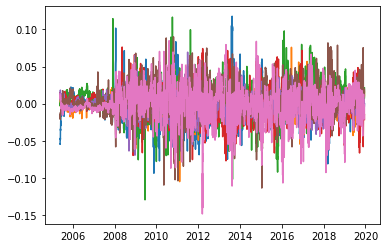

In [50]:
plt.plot(Date, HKhat1-HK)

In [51]:
junk = np.var(HKhat1,axis=0)

junk1 = np.var(HK, axis= 0)

ERROR = HKhat1 -HK
SEE = np.sum(ERROR**2, axis=0)
SEE1 = np.sum(SEE)
print(SEE1)
RSQ_HK_NPC = junk/junk1
print(RSQ_HK_NPC)
print(np.min(RSQ_HK_NPC))

# Format the dates as 'YYYY-MM-DD'


9.315954256425325
[0.96869865 0.9981708  0.99708244 0.9846407  1.00267237 1.02167694
 1.02653169]
0.9686986536787953


- We see that the min value of the NPC $R^2$ is .96, almost twice as good at the PC.  

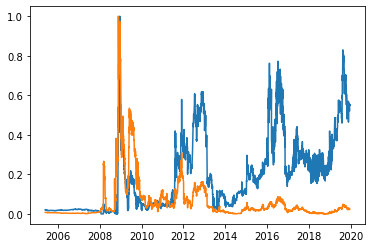

In [58]:
encoded_HK= scaler.fit_transform(encoded_HK)
plt.plot(Date, encoded_HK)

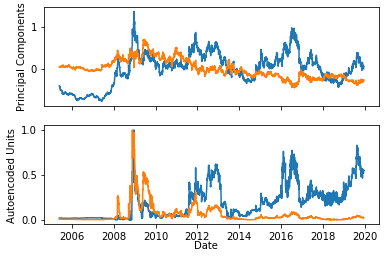

In [62]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot the first subplot
ax1.plot(Date, PC)
ax1.set_ylabel('Principal Components')

# Plot the second subplot
ax2.plot(Date, encoded_HK)
ax2.set_ylabel('Autoencoded Units')

# Add a common x-axis label
fig.text(0.5, 0.04, 'Date', ha='center')

# Set the y-axis limits to be the same on both subplots


plt.show()







In [56]:
np.std(encoded_HK,0)

array([6.806936, 7.074067], dtype=float32)

- We see that the standard deviations are about the same for the two nonlinear principal components

In [55]:
print(junk/junk1)

[0.96869865 0.9981708  0.99708244 0.9846407  1.00267237 1.02167694
 1.02653169]


Of course, the real proof of the pudding is in out of sample prediction, especially with rolling window regression.


In [19]:
print(USA.shape)

(3798, 177)


In [20]:
print(HK.shape)

(3798, 7)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3798 samples in 0.003s...
[t-SNE] Computed neighbors for 3798 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3798
[t-SNE] Computed conditional probabilities for sample 2000 / 3798
[t-SNE] Computed conditional probabilities for sample 3000 / 3798
[t-SNE] Computed conditional probabilities for sample 3798 / 3798
[t-SNE] Mean sigma: 0.038016
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.440292
[t-SNE] KL divergence after 5000 iterations: 0.301768


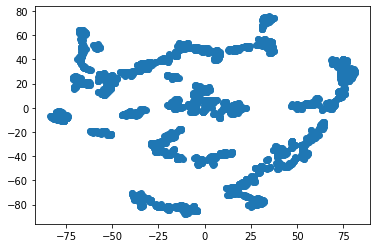

In [22]:
from sklearn.manifold import TSNE
import numpy as np

# Generate some example data

XX = USA

# Initialize and fit the t-SNE model
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
XX_tsne = tsne.fit_transform(XX)

# Visualize the results
import matplotlib.pyplot as plt
plt.scatter(XX_tsne[:, 0], XX_tsne[:, 1])
plt.show()

Text(0.5, 1.0, 'TSNE Components')

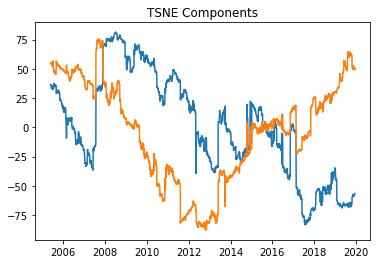

In [25]:
plt.plot(Date, XX_tsne)
plt.title('TSNE Components')

In [28]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_compression(X, k):
    """
    Performs k-nearest neighbor data compression on a large N by K matrix X.

    Parameters:
    X (numpy.ndarray): The N by K matrix to be compressed.
    k (int): The number of nearest neighbors to consider.

    Returns:
    compressed_X (numpy.ndarray): The compressed N by k matrix.
    """

    # Find the k nearest neighbors for each data point
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute the mean of the k nearest neighbors for each data point
    compressed_X = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[0]):
        compressed_X[i,:] = np.mean(X[indices[i,:],:], axis=0)

    # Select the first k columns of the compressed matrix
    compressed_X = compressed_X[:,:k]

    return compressed_X



In [32]:
USA_compressed = knn_compression(USA,4)

In [33]:
print(USA_compressed.shape)


(3798, 4)


Text(0.5, 1.0, 'K-Nearest Neighbor')

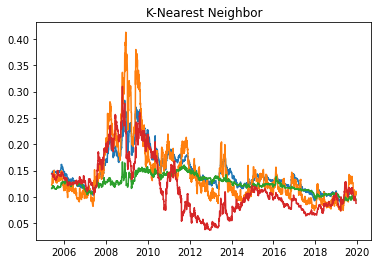

In [35]:
plt.plot(Date, USA_compressed)
plt.title('K-Nearest Neighbor')

In [36]:
import numpy as np

def standardize(X):
    """
    Standardizes a large N by K matrix X.

    Parameters:
    X (numpy.ndarray): The N by K matrix to be standardized.

    Returns:
    X_std (numpy.ndarray): The standardized N by K matrix.
    """

    # Calculate the mean and standard deviation of each column
    col_mean = np.mean(X, axis=0)
    col_std = np.std(X, axis=0)

    # Subtract the mean from each column and divide by the standard deviation
    X_std = (X - col_mean) / col_std

    return X_std


In [37]:
USAstd = standardize(USA)

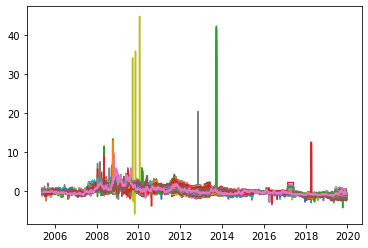

In [39]:
plt.plot(Date, USAstd)

In [44]:
import numpy as np
from sklearn.decomposition import FactorAnalysis

def factor_analysis(X, n_components):
    """
    Performs dynamic factor analysis on a large n by k matrix X.

    Parameters:
    X (numpy.ndarray): The n by k matrix to be analyzed.
    n_components (int): The number of factors to extract.

    Returns:
    transformed_X (numpy.ndarray): The transformed n by n_components matrix.
    """

    # Fit a factor analysis model to the data
    fa = FactorAnalysis(n_components=n_components).fit(X)

    # Transform the data using the factor analysis model
    transformed_X = fa.transform(X)

    return transformed_X


In [45]:
USA_factors = factor_analysis(USAstd,2)

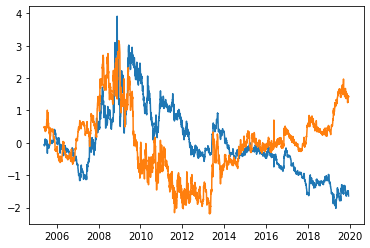

In [42]:
plt.plot(Date, USA_factors)

In [46]:
import numpy as np
from scipy.linalg import eig

def dynamic_factor_analysis(X, n_factors, n_lags):
    """
    Performs dynamic factor analysis on a large n by k matrix X.

    Parameters:
    X (numpy.ndarray): The n by k matrix to be analyzed.
    n_factors (int): The number of factors to extract.
    n_lags (int): The number of time lags to use.

    Returns:
    transformed_X (numpy.ndarray): The transformed n by n_factors matrix.
    """

    # Construct lagged matrix
    n_obs = X.shape[0]
    lagged_X = np.zeros((n_obs - n_lags, n_lags * X.shape[1]))
    for i in range(n_lags):
        lagged_X[:, i*X.shape[1]:(i+1)*X.shape[1]] = X[i:n_obs-n_lags+i, :]

    # Perform eigenvalue decomposition of lagged matrix
    cov = np.cov(lagged_X, rowvar=False)
    eigenvals, eigenvecs = eig(cov)

    # Select the largest eigenvalues and eigenvectors
    indices = np.argsort(eigenvals)[::-1][:n_factors]
    factor_vecs = eigenvecs[:, indices]

    # Compute factor loadings and transform data
    factor_loadings = np.zeros((X.shape[1], n_factors))
    transformed_X = np.zeros((n_obs - n_lags, n_factors))
    for i in range(n_factors):
        factor_loadings[:, i] = np.mean(lagged_X.dot(factor_vecs[:, i]), axis=0)
        transformed_X[:, i] = X[n_lags:, :].dot(factor_loadings[:, i])

    return transformed_X


In [47]:
USA_dfn = dynamic_factor_analysis(USAstd,2,1)

In [48]:
print(USA_dfn.shape)

(3797, 2)


In [49]:
print(Date.shape)

(3798,)


In [50]:
Date1 = Date[1:]

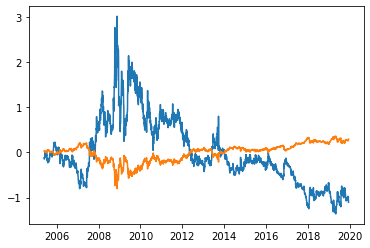

In [52]:
plt.plot(Date1, USA_dfn)